In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional
from collections import Counter, defaultdict
import math
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

[ORDERED] Heaps fit: V ≈ 1.5 * N^0.771   (R²=0.995)
[SHUFFLE] beta mean=0.778  std=0.051
[SHUFFLE] K    mean=1.55  std=0.44


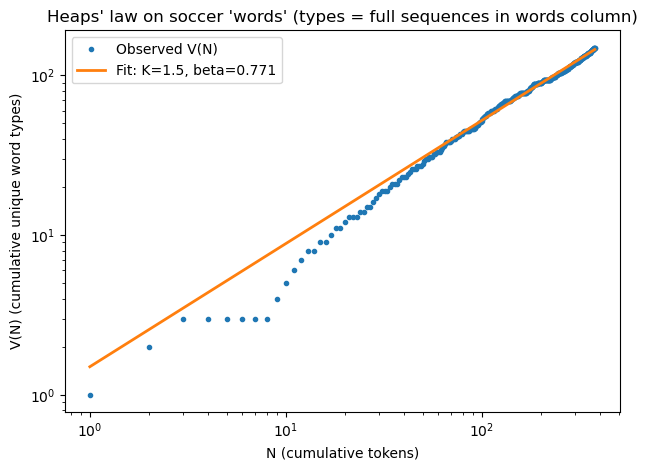

In [3]:
# ----------------------------
# 1) Load + preprocessing
# ----------------------------
CSV_PATH = "AC_Milan_3944962.csv"  # <-- il tuo file

def load_tokens(csv_path: str, col: str = "words") -> np.ndarray:
    df = pd.read_csv(csv_path)
    if col not in df.columns:
        raise ValueError(f"Column '{col}' not found. Available columns: {list(df.columns)}")
    tokens = (
        df[col]
        .dropna()
        .astype(str)
        .str.strip()
    )
    tokens = tokens[tokens != ""].to_numpy()
    if len(tokens) == 0:
        raise ValueError("No valid tokens found after dropping NaNs/empty strings.")
    return tokens


# ----------------------------
# 2) Heaps curve V(N)
# ----------------------------
def heaps_curve(tokens: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    tokens: sequenza di parole (types = stringhe complete).
    Returns:
        N: [1..T] cumulativo token
        V: vocabolario cumulativo (unique types) lungo la sequenza
    """
    seen = set()
    V = np.empty(len(tokens), dtype=int)
    for i, tok in enumerate(tokens):
        seen.add(tok)
        V[i] = len(seen)
    N = np.arange(1, len(tokens) + 1)
    return N, V


# ----------------------------
# 3) Fit Heaps: V = K * N^beta
# ----------------------------
@dataclass
class HeapsFit:
    K: float
    beta: float
    r2: float

def fit_heaps(N: np.ndarray, V: np.ndarray, min_n: int = 50) -> HeapsFit:
    """
    Fit lineare su log-log: log(V) = log(K) + beta*log(N)
    min_n: evita i primissimi punti (rumorosi) usando N >= min_n
    """
    mask = N >= min_n
    N2, V2 = N[mask], V[mask]

    x = np.log(N2)
    y = np.log(V2)

    # regressione lineare y = a + b x
    b, a = np.polyfit(x, y, deg=1)
    y_hat = a + b * x

    ss_res = np.sum((y - y_hat) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

    K = float(np.exp(a))
    beta = float(b)
    return HeapsFit(K=K, beta=beta, r2=float(r2))


# ----------------------------
# 4) Bootstrap over shuffles (opzionale ma consigliato)
# ----------------------------
def heaps_bootstrap(tokens: np.ndarray, n_boot: int = 50, seed: int = 42, min_n: int = 50
                   ) -> Dict[str, np.ndarray]:
    """
    Ripete l'analisi su permutazioni casuali dei token (per stimare robustezza di beta).
    Restituisce array di K, beta, r2.
    """
    rng = np.random.default_rng(seed)
    Ks, betas, r2s = [], [], []

    for _ in range(n_boot):
        perm = rng.permutation(tokens)
        N, V = heaps_curve(perm)
        fit = fit_heaps(N, V, min_n=min_n)
        Ks.append(fit.K)
        betas.append(fit.beta)
        r2s.append(fit.r2)

    return {
        "K": np.array(Ks, dtype=float),
        "beta": np.array(betas, dtype=float),
        "r2": np.array(r2s, dtype=float),
    }


# ----------------------------
# 5) Run + plot
# ----------------------------
tokens = load_tokens(CSV_PATH, col="words")

# Curva sulla sequenza (ordine righe del CSV)
N, V = heaps_curve(tokens)
fit = fit_heaps(N, V, min_n=50)
print(f"[ORDERED] Heaps fit: V ≈ {fit.K:.3g} * N^{fit.beta:.3f}   (R²={fit.r2:.3f})")

# Bootstrap su shuffle (se non hai un vero ordine temporale affidabile)
boot = heaps_bootstrap(tokens, n_boot=100, seed=42, min_n=50)
print(f"[SHUFFLE] beta mean={boot['beta'].mean():.3f}  std={boot['beta'].std():.3f}")
print(f"[SHUFFLE] K    mean={boot['K'].mean():.3g}  std={boot['K'].std():.3g}")

# Plot log-log
plt.figure()
plt.loglog(N, V, marker=".", linestyle="None", label="Observed V(N)")

# curva fittata
V_hat = fit.K * (N ** fit.beta)
plt.loglog(N, V_hat, linewidth=2, label=f"Fit: K={fit.K:.2g}, beta={fit.beta:.3f}")

plt.xlabel("N (cumulative tokens)")
plt.ylabel("V(N) (cumulative unique word types)")
plt.title("Heaps' law on soccer 'words' (types = full sequences in words column)")
plt.legend()
plt.tight_layout()
plt.show()

[ORIGINAL] V ≈ 1.5 * N^0.771   (R²=0.995)
[PHONEME-SHUFFLED] V ≈ 1.28 * N^0.819   (R²=0.995)


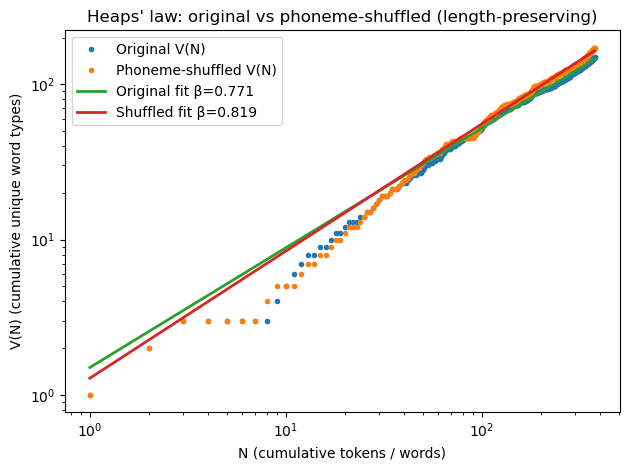

In [6]:
WORDS_COL = "words"


# ----------------------------
# Helpers: load + split to phonemes
# ----------------------------
def load_word_strings(csv_path: str, col: str = "words") -> np.ndarray:
    df = pd.read_csv(csv_path)
    if col not in df.columns:
        raise ValueError(f"Column '{col}' not found. Available: {list(df.columns)}")
    s = df[col].dropna().astype(str).str.strip()
    s = s[s != ""]
    return s.to_numpy()

def word_to_phonemes(word: str, sep: str = "-") -> List[str]:
    # strip extra spaces around each phoneme (important: "Ball Receipt" stays intact)
    return [p.strip() for p in word.split(sep) if p.strip() != ""]

def split_all_words(words: np.ndarray, sep: str = "-") -> Tuple[List[List[str]], np.ndarray]:
    phon_lists = []
    lengths = np.empty(len(words), dtype=int)
    for i, w in enumerate(words):
        ph = word_to_phonemes(w, sep=sep)
        if len(ph) == 0:
            # in case something weird slips through
            ph = [""]  # placeholder; but ideally you won't hit this
        phon_lists.append(ph)
        lengths[i] = len(ph)
    return phon_lists, lengths


# ----------------------------
# Phoneme shuffle with length preservation
# ----------------------------
def shuffle_reconstruct_words(
    phon_lists: List[List[str]],
    lengths: np.ndarray,
    seed: int = 42,
    sep: str = "-"
) -> np.ndarray:
    """
    Takes all phonemes across all words, shuffles them, then rebuilds words
    with the SAME length sequence (lengths[i]) as original.
    Returns: array of reconstructed word strings (same number of words as input)
    """
    pool = np.array([p for ph in phon_lists for p in ph], dtype=object)
    if pool.size != lengths.sum():
        raise RuntimeError("Phoneme pool size mismatch (should equal sum of lengths).")

    rng = np.random.default_rng(seed)
    rng.shuffle(pool)

    rebuilt = []
    idx = 0
    for L in lengths:
        chunk = pool[idx:idx + L]
        idx += L
        rebuilt.append(sep.join(chunk.tolist()))
    return np.array(rebuilt, dtype=object)


# ----------------------------
# Heaps law: V(N) and fit V = K N^beta
# ----------------------------
def heaps_curve(tokens: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    seen = set()
    V = np.empty(len(tokens), dtype=int)
    for i, tok in enumerate(tokens):
        seen.add(tok)
        V[i] = len(seen)
    N = np.arange(1, len(tokens) + 1)
    return N, V

@dataclass
class HeapsFit:
    K: float
    beta: float
    r2: float

def fit_heaps(N: np.ndarray, V: np.ndarray, min_n: int = 50) -> HeapsFit:
    mask = N >= min_n
    N2, V2 = N[mask], V[mask]

    x = np.log(N2)
    y = np.log(V2)

    beta, a = np.polyfit(x, y, deg=1)     # y = a + beta*x
    y_hat = a + beta * x

    ss_res = np.sum((y - y_hat) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

    K = float(np.exp(a))
    return HeapsFit(K=K, beta=float(beta), r2=float(r2))


# ----------------------------
# Run: original vs phoneme-shuffled (length-preserving)
# ----------------------------
words = load_word_strings(CSV_PATH, col=WORDS_COL)
phon_lists, lengths = split_all_words(words, sep="-")

# Original Heaps
N0, V0 = heaps_curve(words)
fit0 = fit_heaps(N0, V0, min_n=50)
print(f"[ORIGINAL] V ≈ {fit0.K:.3g} * N^{fit0.beta:.3f}   (R²={fit0.r2:.3f})")

# One phoneme-shuffle reconstruction
shuffled_words = shuffle_reconstruct_words(phon_lists, lengths, seed=42, sep="-")
N1, V1 = heaps_curve(shuffled_words)
fit1 = fit_heaps(N1, V1, min_n=50)
print(f"[PHONEME-SHUFFLED] V ≈ {fit1.K:.3g} * N^{fit1.beta:.3f}   (R²={fit1.r2:.3f})")

# Plot comparison (log-log)
plt.figure()
plt.loglog(N0, V0, marker=".", linestyle="None", label="Original V(N)")
plt.loglog(N1, V1, marker=".", linestyle="None", label="Phoneme-shuffled V(N)")

plt.loglog(N0, fit0.K * (N0 ** fit0.beta), linewidth=2, label=f"Original fit β={fit0.beta:.3f}")
plt.loglog(N1, fit1.K * (N1 ** fit1.beta), linewidth=2, label=f"Shuffled fit β={fit1.beta:.3f}")

plt.xlabel("N (cumulative tokens / words)")
plt.ylabel("V(N) (cumulative unique word types)")
plt.title("Heaps' law: original vs phoneme-shuffled (length-preserving)")
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
SEP = "-"


# ----------------------------
# Load and split into phoneme sequences
# ----------------------------
def load_words(csv_path: str, col: str) -> np.ndarray:
    df = pd.read_csv(csv_path)
    s = df[col].dropna().astype(str).str.strip()
    s = s[s != ""]
    return s.to_numpy()

def word_to_phonemes(word: str, sep: str = "-"):
    return [p.strip() for p in word.split(sep) if p.strip()]

def flatten_bigrams_from_words(words: np.ndarray, sep: str = "-"):
    """
    Return bigrams across phoneme streams WITHIN each word.
    (If you want bigrams across word boundaries too, we can add that.)
    """
    bigrams = []
    unigrams = []
    for w in words:
        ph = word_to_phonemes(w, sep)
        unigrams.extend(ph)
        for i in range(len(ph)-1):
            bigrams.append((ph[i], ph[i+1]))
    return unigrams, bigrams

# ----------------------------
# Your null: global phoneme shuffle with length preservation
# ----------------------------
def split_all(words: np.ndarray, sep: str = "-"):
    phon_lists = []
    lengths = np.empty(len(words), dtype=int)
    for i, w in enumerate(words):
        ph = word_to_phonemes(w, sep)
        phon_lists.append(ph)
        lengths[i] = len(ph)
    return phon_lists, lengths

def shuffle_reconstruct_words(phon_lists, lengths, seed=42, sep="-"):
    pool = np.array([p for ph in phon_lists for p in ph], dtype=object)
    rng = np.random.default_rng(seed)
    rng.shuffle(pool)
    out = []
    idx = 0
    for L in lengths:
        out.append(sep.join(pool[idx:idx+L].tolist()))
        idx += L
    return np.array(out, dtype=object)

# ----------------------------
# Metrics: MI (adjacent phonemes) and bigram perplexity
# ----------------------------
def mutual_information_adjacent(unigrams, bigrams):
    """
    MI = sum_{x,y} p(x,y) log2( p(x,y) / (p(x)p(y)) )
    """
    uni = Counter(unigrams)
    bi = Counter(bigrams)
    total_u = sum(uni.values())
    total_b = sum(bi.values())

    # p(x), p(y)
    p = {k: v / total_u for k, v in uni.items()}

    mi = 0.0
    for (x, y), c in bi.items():
        pxy = c / total_b
        mi += pxy * math.log2(pxy / (p[x] * p[y]))
    return mi

def bigram_perplexity(unigrams, bigrams, alpha=0.5):
    """
    Bigram model with add-alpha smoothing:
      P(y|x) = (c(x,y) + alpha) / (c(x) + alpha*|V|)
    Cross-entropy over observed bigrams, perplexity = 2^H
    """
    uni = Counter(unigrams)
    bi = Counter(bigrams)
    V = len(uni)

    total_b = sum(bi.values())
    H = 0.0
    for (x, y), cxy in bi.items():
        cx = uni[x]
        p_y_given_x = (cxy + alpha) / (cx + alpha * V)
        H += (cxy / total_b) * (-math.log2(p_y_given_x))
    ppl = 2 ** H
    return H, ppl

# ----------------------------
# Run comparison
# ----------------------------
words = load_words(CSV_PATH, WORDS_COL)

# Original phoneme stream stats
u0, b0 = flatten_bigrams_from_words(words, SEP)
mi0 = mutual_information_adjacent(u0, b0)
H0, ppl0 = bigram_perplexity(u0, b0, alpha=0.5)

# Shuffled reconstruction
phon_lists, lengths = split_all(words, SEP)
shuf_words = shuffle_reconstruct_words(phon_lists, lengths, seed=42, sep=SEP)

u1, b1 = flatten_bigrams_from_words(shuf_words, SEP)
mi1 = mutual_information_adjacent(u1, b1)
H1, ppl1 = bigram_perplexity(u1, b1, alpha=0.5)

print(f"Mutual Information (adjacent phonemes): original={mi0:.4f}  shuffled={mi1:.4f}")
print(f"Bigram cross-entropy H (bits):          original={H0:.4f}  shuffled={H1:.4f}")
print(f"Bigram perplexity:                      original={ppl0:.2f}  shuffled={ppl1:.2f}")

Mutual Information (adjacent phonemes): original=1.8040  shuffled=0.1183
Bigram cross-entropy H (bits):          original=0.7452  shuffled=2.8581
Bigram perplexity:                      original=1.68  shuffled=7.25


In [14]:
# Load and split into phoneme sequences
# ----------------------------
def load_words(csv_path: str, col: str) -> np.ndarray:
    df = pd.read_csv(csv_path)
    s = df[col].dropna().astype(str).str.strip()
    s = s[s != ""]
    return s.to_numpy()

def word_to_phonemes(word: str, sep: str = "-"):
    return [p.strip() for p in word.split(sep) if p.strip()]

def flatten_bigrams_from_words(words: np.ndarray, sep: str = "-"):
    """
    Return bigrams across phoneme streams WITHIN each word.
    """
    bigrams = []
    unigrams = []
    for w in words:
        ph = word_to_phonemes(w, sep)
        unigrams.extend(ph)
        for i in range(len(ph) - 1):
            bigrams.append((ph[i], ph[i + 1]))
    return unigrams, bigrams


# ----------------------------
# Word-level bigrams (across consecutive words)
# ----------------------------
def word_level_unigrams_bigrams(words: np.ndarray):
    """
    Treat each full 'words' string as a token.
    Build adjacent token bigrams across the sequence order in the CSV.
    """
    tokens = words  # already cleaned array of strings
    if len(tokens) < 2:
        return tokens.tolist(), []
    bigrams = list(zip(tokens[:-1], tokens[1:]))
    return tokens.tolist(), bigrams


# ----------------------------
# Your null: global phoneme shuffle with length preservation
# ----------------------------
def split_all(words: np.ndarray, sep: str = "-"):
    phon_lists = []
    lengths = np.empty(len(words), dtype=int)
    for i, w in enumerate(words):
        ph = word_to_phonemes(w, sep)
        phon_lists.append(ph)
        lengths[i] = len(ph)
    return phon_lists, lengths

def shuffle_reconstruct_words(phon_lists, lengths, seed=42, sep="-"):
    pool = np.array([p for ph in phon_lists for p in ph], dtype=object)
    rng = np.random.default_rng(seed)
    rng.shuffle(pool)
    out = []
    idx = 0
    for L in lengths:
        out.append(sep.join(pool[idx:idx + L].tolist()))
        idx += L
    return np.array(out, dtype=object)


# ----------------------------
# Metrics: MI and bigram perplexity
# ----------------------------
def mutual_information_adjacent(unigrams, bigrams):
    """
    MI = sum_{x,y} p(x,y) log2( p(x,y) / (p(x)p(y)) )
    """
    if len(bigrams) == 0:
        return float("nan")

    uni = Counter(unigrams)
    bi = Counter(bigrams)
    total_u = sum(uni.values())
    total_b = sum(bi.values())

    p = {k: v / total_u for k, v in uni.items()}

    mi = 0.0
    for (x, y), c in bi.items():
        pxy = c / total_b
        mi += pxy * math.log2(pxy / (p[x] * p[y]))
    return mi

def bigram_perplexity(unigrams, bigrams, alpha=0.5):
    """
    Bigram model with add-alpha smoothing:
      P(y|x) = (c(x,y) + alpha) / (c(x) + alpha*|V|)
    Cross-entropy over observed bigrams, perplexity = 2^H
    """
    if len(bigrams) == 0:
        return float("nan"), float("nan")

    uni = Counter(unigrams)
    bi = Counter(bigrams)
    V = len(uni)

    total_b = sum(bi.values())
    H = 0.0
    for (x, y), cxy in bi.items():
        cx = uni[x]
        p_y_given_x = (cxy + alpha) / (cx + alpha * V)
        H += (cxy / total_b) * (-math.log2(p_y_given_x))
    ppl = 2 ** H
    return H, ppl


# ----------------------------
# Run comparison: phoneme-level + word-level
# ----------------------------
words = load_words(CSV_PATH, WORDS_COL)

# Build shuffled reconstruction (null)
phon_lists, lengths = split_all(words, SEP)
shuf_words = shuffle_reconstruct_words(phon_lists, lengths, seed=42, sep=SEP)

# --- (A) Phoneme-level: within-word adjacent phonemes ---
u0_ph, b0_ph = flatten_bigrams_from_words(words, SEP)
mi0_ph = mutual_information_adjacent(u0_ph, b0_ph)
H0_ph, ppl0_ph = bigram_perplexity(u0_ph, b0_ph, alpha=0.5)

u1_ph, b1_ph = flatten_bigrams_from_words(shuf_words, SEP)
mi1_ph = mutual_information_adjacent(u1_ph, b1_ph)
H1_ph, ppl1_ph = bigram_perplexity(u1_ph, b1_ph, alpha=0.5)

print(f"Mutual Information (adjacent phonemes): original={mi0_ph:.4f}  shuffled={mi1_ph:.4f}")
print(f"Bigram cross-entropy H (bits) phonemes: original={H0_ph:.4f}  shuffled={H1_ph:.4f}")
print(f"Bigram perplexity phonemes:             original={ppl0_ph:.2f}  shuffled={ppl1_ph:.2f}")

# --- (B) Word-level: adjacent words (tokens = full sequences) ---
u0_w, b0_w = word_level_unigrams_bigrams(words)
mi0_w = mutual_information_adjacent(u0_w, b0_w)
H0_w, ppl0_w = bigram_perplexity(u0_w, b0_w, alpha=0.5)

u1_w, b1_w = word_level_unigrams_bigrams(shuf_words)
mi1_w = mutual_information_adjacent(u1_w, b1_w)
H1_w, ppl1_w = bigram_perplexity(u1_w, b1_w, alpha=0.5)

print(f"\nMutual Information (adjacent WORD tokens): original={mi0_w:.4f}  shuffled={mi1_w:.4f}")
print(f"Bigram cross-entropy H (bits) WORDS:      original={H0_w:.4f}  shuffled={H1_w:.4f}")
print(f"Bigram perplexity WORDS:                  original={ppl0_w:.2f}  shuffled={ppl1_w:.2f}")

Mutual Information (adjacent phonemes): original=1.8040  shuffled=0.1183
Bigram cross-entropy H (bits) phonemes: original=0.7452  shuffled=2.8581
Bigram perplexity phonemes:             original=1.68  shuffled=7.25

Mutual Information (adjacent WORD tokens): original=3.6244  shuffled=3.7938
Bigram cross-entropy H (bits) WORDS:      original=5.0491  shuffled=5.5379
Bigram perplexity WORDS:                  original=33.11  shuffled=46.46


# Serie A

## Mutual Information - Bigram 

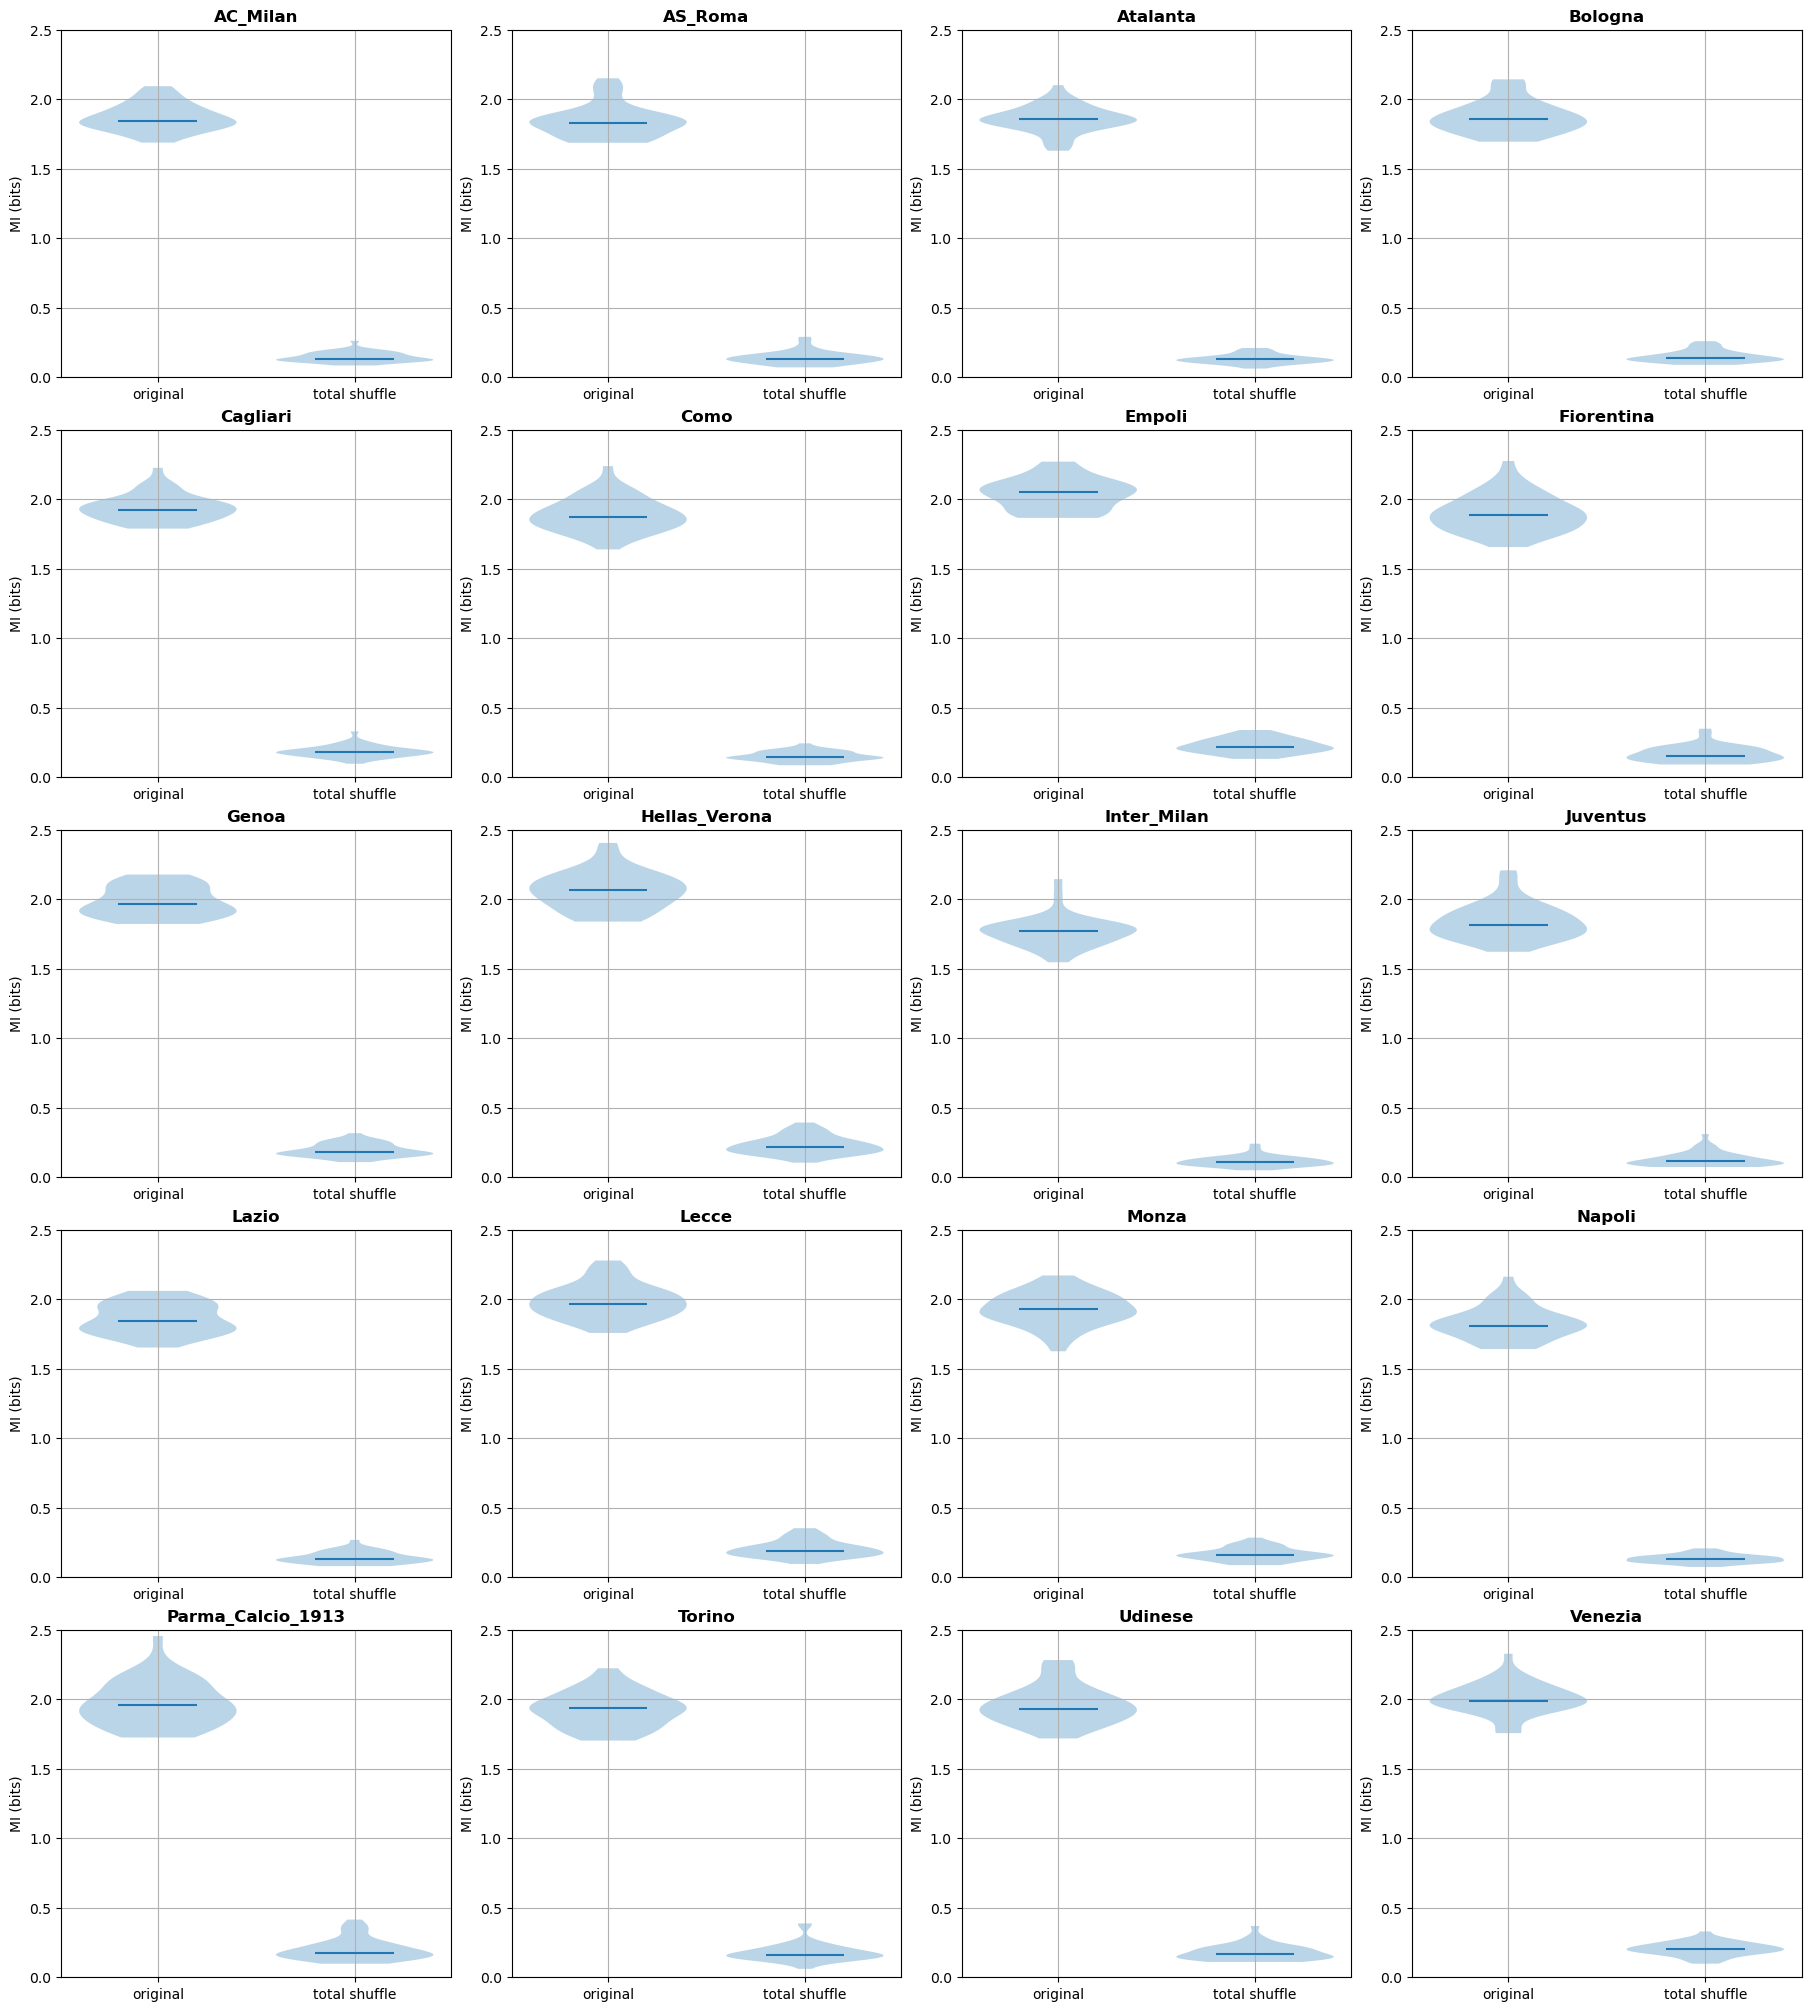

In [35]:
# ----------------------------
# CONFIG
# ----------------------------
file_list = [
    "AC_Milan.csv", "AS_Roma.csv", "Atalanta.csv", "Bologna.csv", "Cagliari.csv",
    "Como.csv", "Empoli.csv", "Fiorentina.csv", "Genoa.csv", "Hellas_Verona.csv",
    "Inter_Milan.csv", "Juventus.csv", "Lazio.csv", "Lecce.csv", "Monza.csv",
    "Napoli.csv", "Parma_Calcio_1913.csv", "Torino.csv",
    "Udinese.csv", "Venezia.csv"
]

TEAM_PREFIXES = [Path(x).stem for x in file_list]
WORDS_COL = "words"
SEP = "-"

# Percorsi (Assicurati che siano corretti per il tuo ambiente)
ORIG_DIR = Path.home() / "Desktop" / "Podemi_and_Football-main" / "Serie_A_24_25_texts"
SHUF_DIR = Path.home() / "Desktop" / "Podemi_and_Football-main" / "Linguistic" / "Serie_A_24_25_full_shuffle"

# ----------------------------
# MI helpers
# ----------------------------
def word_to_phonemes(word: str, sep: str = "-"):
    return [p.strip() for p in word.split(sep) if p.strip()]

def flatten_bigrams_from_words(words: np.ndarray, sep: str = "-"):
    bigrams = []
    unigrams = []
    for w in words:
        ph = word_to_phonemes(w, sep)
        unigrams.extend(ph)
        for i in range(len(ph) - 1):
            bigrams.append((ph[i], ph[i + 1]))
    return unigrams, bigrams

def mutual_information_adjacent(unigrams, bigrams):
    if len(bigrams) == 0:
        return np.nan
    uni = Counter(unigrams)
    bi = Counter(bigrams)
    total_u = sum(uni.values())
    total_b = sum(bi.values())
    p = {k: v / total_u for k, v in uni.items()}
    mi = 0.0
    for (x, y), c in bi.items():
        pxy = c / total_b
        mi += pxy * math.log2(pxy / (p[x] * p[y]))
    return mi

def read_words_column(csv_path: Path, col="words") -> np.ndarray:
    try:
        df = pd.read_csv(csv_path)
    except Exception:
        try:
            df = pd.read_csv(csv_path, encoding="latin-1")
        except:
            return np.array([], dtype=object)
    if col not in df.columns:
        return np.array([], dtype=object)
    s = df[col].dropna().astype(str).str.strip()
    s = s[s != ""]
    return s.to_numpy()

def mi_for_match_file(csv_path: Path) -> float:
    words = read_words_column(csv_path, col=WORDS_COL)
    if len(words) == 0:
        return np.nan
    unigrams, bigrams = flatten_bigrams_from_words(words, sep=SEP)
    return mutual_information_adjacent(unigrams, bigrams)

# ----------------------------
# Raccolta dati e calcolo limiti globali
# ----------------------------
orig_files = [p for p in ORIG_DIR.iterdir() if p.is_file() and p.suffix.lower() == ".csv"] if ORIG_DIR.exists() else []
team_to_vals = {team: {"original": [], "total shuffle": []} for team in TEAM_PREFIXES}

all_mi_values = []

for team in TEAM_PREFIXES:
    team_files = [p for p in orig_files if p.name == f"{team}.csv" or p.name.startswith(team + "_")]
    for p in team_files:
        shuf_p = SHUF_DIR / p.name
        if not shuf_p.exists(): continue
        
        mi_o = mi_for_match_file(p)
        mi_s = mi_for_match_file(shuf_p)
        
        if not np.isnan(mi_o):
            team_to_vals[team]["original"].append(mi_o)
            all_mi_values.append(mi_o)
        if not np.isnan(mi_s):
            team_to_vals[team]["total shuffle"].append(mi_s)
            all_mi_values.append(mi_s)

# Calcolo limiti per asse Y comune
if all_mi_values:
    y_min = math.floor(min(all_mi_values) * 2) / 2  # Arrotonda per difetto allo 0.5 più vicino
    y_max = math.ceil(max(all_mi_values) * 2) / 2   # Arrotonda per eccesso allo 0.5 più vicino
else:
    y_min, y_max = 0, 5

# ----------------------------
# Plot
# ----------------------------
fig, axes = plt.subplots(5, 4, figsize=(18, 20), constrained_layout=True)
axes = axes.ravel()

for i, team in enumerate(TEAM_PREFIXES):
    ax = axes[i]
    orig_vals = np.array(team_to_vals[team]["original"], dtype=float)
    shuf_vals = np.array(team_to_vals[team]["total shuffle"], dtype=float)
    
    orig_vals = orig_vals[np.isfinite(orig_vals)]
    shuf_vals = shuf_vals[np.isfinite(shuf_vals)]
    
    if len(orig_vals) > 0 and len(shuf_vals) > 0:
        parts = ax.violinplot([orig_vals, shuf_vals], positions=[1, 2], 
                               widths=0.8, showmedians=True, showextrema=False)
    
    # --- UNIFORMITÀ SCALA ---
    ax.set_ylim(y_min, y_max)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    # ------------------------

    ax.set_title(f"{team}", fontweight="bold")
    ax.set_xticks([1, 2])
    ax.set_xticklabels(["original", "total shuffle"])
    ax.set_ylabel("MI (bits)")
    ax.grid()

    if len(orig_vals) == 0:
        ax.text(0.5, 0.5, "No data", transform=ax.transAxes, ha="center")

for j in range(len(TEAM_PREFIXES), len(axes)):
    axes[j].axis("off")

plt.show()

## Mutual Information - Trigram

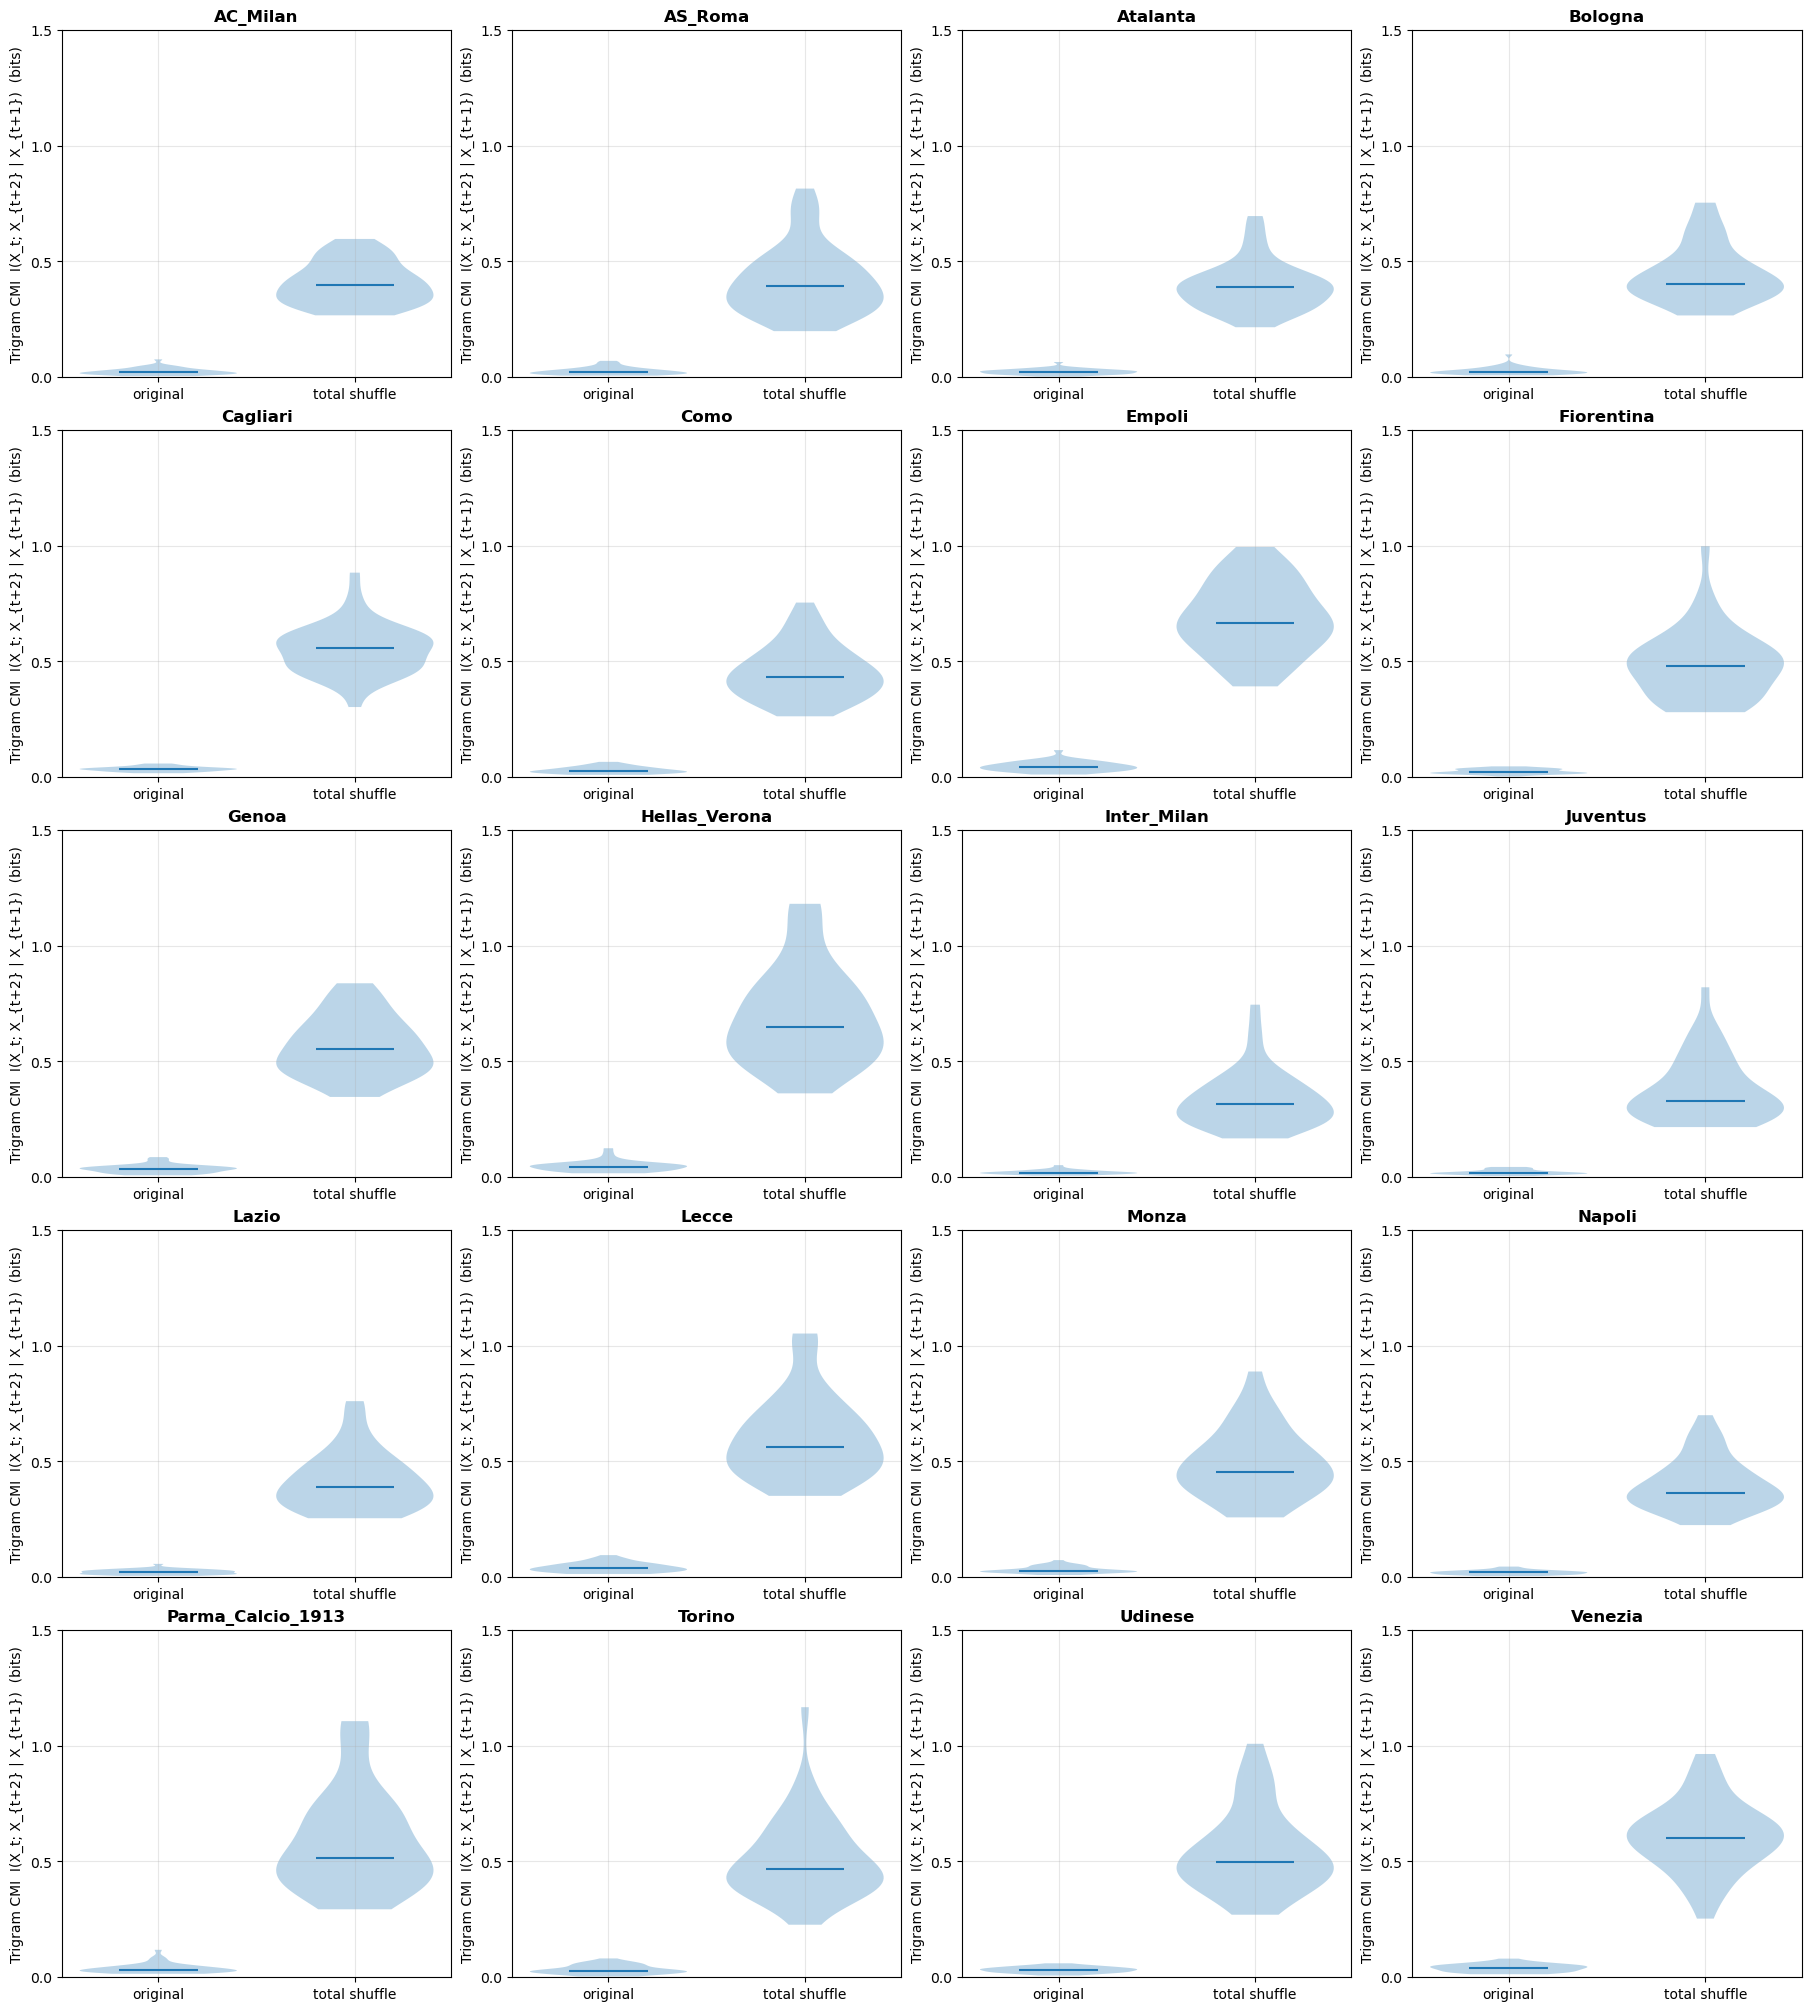

In [43]:
# ----------------------------
# CONFIG
# ----------------------------
file_list = [
    "AC_Milan.csv", "AS_Roma.csv", "Atalanta.csv", "Bologna.csv", "Cagliari.csv",
    "Como.csv", "Empoli.csv", "Fiorentina.csv", "Genoa.csv", "Hellas_Verona.csv",
    "Inter_Milan.csv", "Juventus.csv", "Lazio.csv", "Lecce.csv", "Monza.csv",
    "Napoli.csv", "Parma_Calcio_1913.csv", "Torino.csv",
    "Udinese.csv", "Venezia.csv"
]

TEAM_PREFIXES = [Path(x).stem for x in file_list]
WORDS_COL = "words"
SEP = "-"

ORIG_DIR = Path.home() / "Desktop" / "Podemi_and_Football-main" / "Serie_A_24_25_texts"
SHUF_DIR = Path.home() / "Desktop" / "Podemi_and_Football-main" / "Linguistic" / "Serie_A_24_25_full_shuffle"

# ----------------------------
# Tokenization
# ----------------------------
def word_to_phonemes(word: str, sep: str = "-"):
    return [p.strip() for p in word.split(sep) if p.strip()]

def flatten_trigrams_from_words(words: np.ndarray, sep: str = "-"):
    """
    Return:
      - unigrams list
      - trigrams list of (x, y, z) representing x->y->z within each word
    Words with <3 phonemes contribute 0 trigrams (they are simply ignored for trigram stats).
    """
    trigrams = []
    unigrams = []
    for w in words:
        ph = word_to_phonemes(w, sep)
        unigrams.extend(ph)
        for i in range(len(ph) - 2):
            trigrams.append((ph[i], ph[i + 1], ph[i + 2]))
    return unigrams, trigrams

# ----------------------------
# Trigram MI: conditional mutual information I(X;Z | Y)
# ----------------------------
def conditional_mutual_information_trigram(trigrams):
    """
    Compute I(X; Z | Y) from trigram counts:
      I(X;Z|Y) = sum_{x,y,z} p(x,y,z) * log2( p(z|x,y) / p(z|y) )

    Uses empirical probabilities from trigram counts.
    """
    if len(trigrams) == 0:
        return np.nan

    tri = Counter(trigrams)
    total_t = sum(tri.values())

    # counts for conditioning
    xy = Counter()
    yz = Counter()
    y_ = Counter()

    for (x, y, z), c in tri.items():
        xy[(x, y)] += c
        yz[(y, z)] += c
        y_[y] += c

    cmi = 0.0
    for (x, y, z), cxyz in tri.items():
        p_xyz = cxyz / total_t

        p_z_given_xy = cxyz / xy[(x, y)]
        p_z_given_y  = yz[(y, z)] / y_[y]

        cmi += p_xyz * math.log2(p_z_given_xy / p_z_given_y)

    return cmi

# ----------------------------
# I/O
# ----------------------------
def read_words_column(csv_path: Path, col="words") -> np.ndarray:
    try:
        df = pd.read_csv(csv_path)
    except Exception:
        try:
            df = pd.read_csv(csv_path, encoding="latin-1")
        except Exception:
            return np.array([], dtype=object)

    if col not in df.columns:
        return np.array([], dtype=object)

    s = df[col].dropna().astype(str).str.strip()
    s = s[s != ""]
    return s.to_numpy()

def trigram_mi_for_match_file(csv_path: Path) -> float:
    words = read_words_column(csv_path, col=WORDS_COL)
    if len(words) == 0:
        return np.nan
    _, trigrams = flatten_trigrams_from_words(words, sep=SEP)
    return conditional_mutual_information_trigram(trigrams)

# ----------------------------
# Collect values per team
# ----------------------------
orig_files = [p for p in ORIG_DIR.iterdir() if p.is_file() and p.suffix.lower() == ".csv"] if ORIG_DIR.exists() else []
team_to_vals = {team: {"original": [], "total shuffle": []} for team in TEAM_PREFIXES}

all_vals = []

for team in TEAM_PREFIXES:
    team_files = [p for p in orig_files if p.name == f"{team}.csv" or p.name.startswith(team + "_")]
    for p in team_files:
        shuf_p = SHUF_DIR / p.name
        if not shuf_p.exists():
            continue

        v_o = trigram_mi_for_match_file(p)
        v_s = trigram_mi_for_match_file(shuf_p)

        if np.isfinite(v_o):
            team_to_vals[team]["original"].append(v_o)
            all_vals.append(v_o)
        if np.isfinite(v_s):
            team_to_vals[team]["total shuffle"].append(v_s)
            all_vals.append(v_s)

# Global y-limits
if all_vals:
    y_min = math.floor(min(all_vals) * 2) / 2
    y_max = math.ceil(max(all_vals) * 2) / 2
else:
    y_min, y_max = 0, 5

# ----------------------------
# Plot (5x4)
# ----------------------------
fig, axes = plt.subplots(5, 4, figsize=(18, 20), constrained_layout=True)
axes = axes.ravel()

for i, team in enumerate(TEAM_PREFIXES):
    ax = axes[i]

    orig_vals = np.array(team_to_vals[team]["original"], dtype=float)
    shuf_vals = np.array(team_to_vals[team]["total shuffle"], dtype=float)

    orig_vals = orig_vals[np.isfinite(orig_vals)]
    shuf_vals = shuf_vals[np.isfinite(shuf_vals)]

    if len(orig_vals) > 0 and len(shuf_vals) > 0:
        ax.violinplot([orig_vals, shuf_vals], positions=[1, 2],
                      widths=0.8, showmedians=True, showextrema=False)
    else:
        ax.text(0.5, 0.5, "No data", transform=ax.transAxes, ha="center", va="center")

    ax.set_ylim(y_min, y_max)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))

    ax.set_title(f"{team}", fontweight="bold")
    ax.set_xticks([1, 2])
    ax.set_xticklabels(["original", "total shuffle"])
    ax.set_ylabel("Trigram CMI  I(X_t; X_{t+2} | X_{t+1})  (bits)")
    ax.grid(True, alpha=0.3)

for j in range(len(TEAM_PREFIXES), len(axes)):
    axes[j].axis("off")

plt.show()

In [42]:
print("\n=== DEBUG: counts per team ===")
for team in TEAM_PREFIXES:
    n_orig = len(team_to_vals[team]["original"])
    n_shuf = len(team_to_vals[team]["total shuffle"])
    # stima: quante partite sono state viste (solo quelle che matchano il prefisso)
    team_files = [p for p in orig_files if p.name == f"{team}.csv" or p.name.startswith(team + "_")]
    print(f"{team:20s} files_found={len(team_files):3d}  valid_orig={n_orig:3d}  valid_shuf={n_shuf:3d}")


=== DEBUG: counts per team ===
AC_Milan             files_found= 38  valid_orig= 38  valid_shuf= 38
AS_Roma              files_found= 38  valid_orig= 38  valid_shuf= 38
Atalanta             files_found= 38  valid_orig= 38  valid_shuf= 38
Bologna              files_found= 38  valid_orig= 38  valid_shuf= 38
Cagliari             files_found= 38  valid_orig= 38  valid_shuf= 38
Como                 files_found= 38  valid_orig= 38  valid_shuf= 38
Empoli               files_found= 38  valid_orig= 38  valid_shuf= 38
Fiorentina           files_found= 38  valid_orig= 38  valid_shuf= 38
Genoa                files_found= 38  valid_orig= 38  valid_shuf= 38
Hellas_Verona        files_found= 38  valid_orig= 38  valid_shuf= 38
Napoli               files_found= 38  valid_orig= 38  valid_shuf= 38
Parma_Calcio_1913    files_found= 38  valid_orig= 38  valid_shuf= 38
Torino               files_found= 38  valid_orig= 38  valid_shuf= 38
Udinese              files_found= 38  valid_orig= 38  valid_shuf= 38
Ve

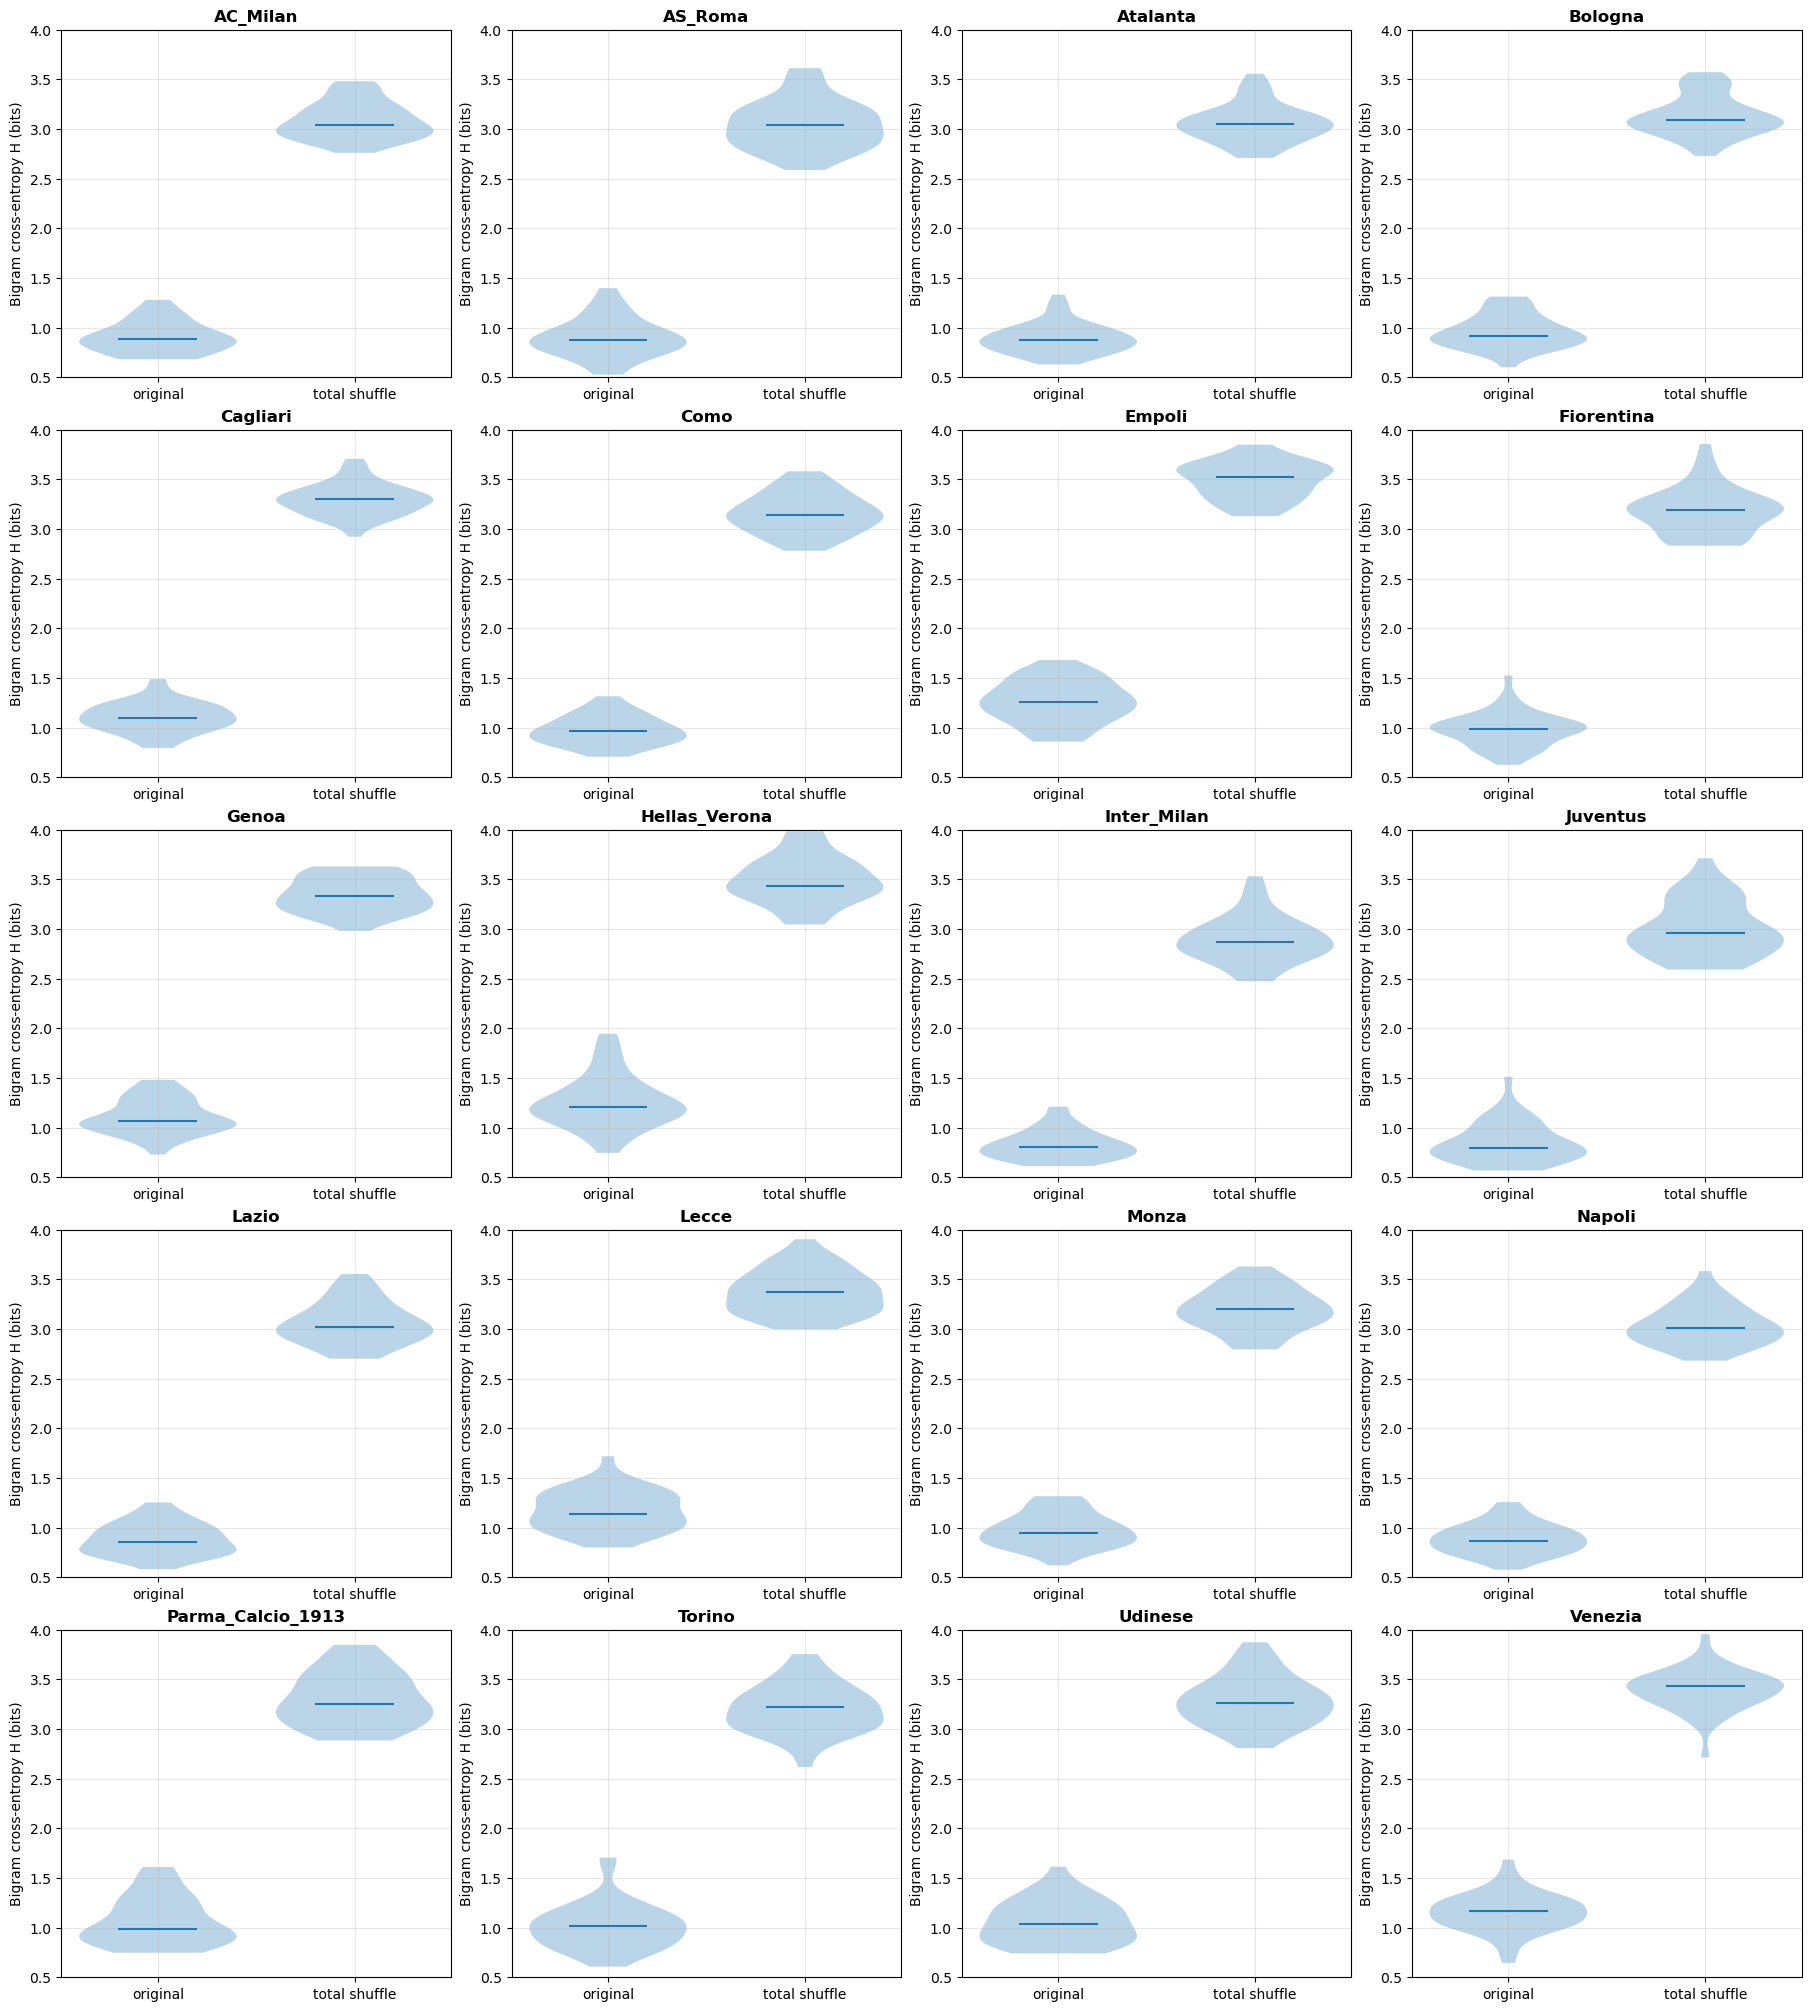

In [39]:
# ----------------------------
# CONFIG
# ----------------------------
file_list = [
    "AC_Milan.csv", "AS_Roma.csv", "Atalanta.csv", "Bologna.csv", "Cagliari.csv",
    "Como.csv", "Empoli.csv", "Fiorentina.csv", "Genoa.csv", "Hellas_Verona.csv",
    "Inter_Milan.csv", "Juventus.csv", "Lazio.csv", "Lecce.csv", "Monza.csv",
    "Napoli.csv", "Parma_Calcio_1913.csv", "Torino.csv",
    "Udinese.csv", "Venezia.csv"
]

TEAM_PREFIXES = [Path(x).stem for x in file_list]
WORDS_COL = "words"
SEP = "-"

ORIG_DIR = Path.home() / "Desktop" / "Podemi_and_Football-main" / "Serie_A_24_25_texts"
SHUF_DIR = Path.home() / "Desktop" / "Podemi_and_Football-main" / "Linguistic" / "Serie_A_24_25_full_shuffle"

ALPHA = 0.5  # add-alpha smoothing (same as your earlier setting)

# ----------------------------
# Helpers: tokenize into phoneme bigrams (within-word)
# ----------------------------
def word_to_phonemes(word: str, sep: str = "-"):
    return [p.strip() for p in word.split(sep) if p.strip()]

def flatten_bigrams_from_words(words: np.ndarray, sep: str = "-"):
    bigrams = []
    unigrams = []
    for w in words:
        ph = word_to_phonemes(w, sep)
        unigrams.extend(ph)
        for i in range(len(ph) - 1):
            bigrams.append((ph[i], ph[i + 1]))
    return unigrams, bigrams

def read_words_column(csv_path: Path, col="words") -> np.ndarray:
    try:
        df = pd.read_csv(csv_path)
    except Exception:
        try:
            df = pd.read_csv(csv_path, encoding="latin-1")
        except Exception:
            return np.array([], dtype=object)

    if col not in df.columns:
        return np.array([], dtype=object)

    s = df[col].dropna().astype(str).str.strip()
    s = s[s != ""]
    return s.to_numpy()

# ----------------------------
# Metric: Bigram cross-entropy H (bits)
# ----------------------------
def bigram_cross_entropy_bits(unigrams, bigrams, alpha=0.5):
    """
    Bigram model with add-alpha smoothing:
      P(y|x) = (c(x,y) + alpha) / (c(x) + alpha*|V|)
    Cross-entropy over observed bigrams:
      H = sum_{x,y} p_data(x,y) * [-log2 P(y|x)]
    """
    if len(bigrams) == 0:
        return np.nan

    uni = Counter(unigrams)
    bi = Counter(bigrams)
    V = len(uni)
    if V == 0:
        return np.nan

    total_b = sum(bi.values())
    H = 0.0
    for (x, y), cxy in bi.items():
        cx = uni[x]
        p_y_given_x = (cxy + alpha) / (cx + alpha * V)
        H += (cxy / total_b) * (-math.log2(p_y_given_x))
    return H

def H_for_match_file(csv_path: Path) -> float:
    words = read_words_column(csv_path, col=WORDS_COL)
    if len(words) == 0:
        return np.nan
    unigrams, bigrams = flatten_bigrams_from_words(words, sep=SEP)
    return bigram_cross_entropy_bits(unigrams, bigrams, alpha=ALPHA)

# ----------------------------
# Collect values per team
# ----------------------------
orig_files = [p for p in ORIG_DIR.iterdir() if p.is_file() and p.suffix.lower() == ".csv"] if ORIG_DIR.exists() else []
team_to_vals = {team: {"original": [], "total shuffle": []} for team in TEAM_PREFIXES}

all_H_values = []

for team in TEAM_PREFIXES:
    team_files = [p for p in orig_files if p.name == f"{team}.csv" or p.name.startswith(team + "_")]

    for p in team_files:
        shuf_p = SHUF_DIR / p.name
        if not shuf_p.exists():
            continue

        H_o = H_for_match_file(p)
        H_s = H_for_match_file(shuf_p)

        if np.isfinite(H_o):
            team_to_vals[team]["original"].append(H_o)
            all_H_values.append(H_o)
        if np.isfinite(H_s):
            team_to_vals[team]["total shuffle"].append(H_s)
            all_H_values.append(H_s)

# Global y-limits
if all_H_values:
    y_min = math.floor(min(all_H_values) * 2) / 2
    y_max = math.ceil(max(all_H_values) * 2) / 2
else:
    y_min, y_max = 0, 6

# ----------------------------
# Plot (5x4)
# ----------------------------
fig, axes = plt.subplots(5, 4, figsize=(18, 20), constrained_layout=True)
axes = axes.ravel()

for i, team in enumerate(TEAM_PREFIXES):
    ax = axes[i]

    orig_vals = np.array(team_to_vals[team]["original"], dtype=float)
    shuf_vals = np.array(team_to_vals[team]["total shuffle"], dtype=float)

    orig_vals = orig_vals[np.isfinite(orig_vals)]
    shuf_vals = shuf_vals[np.isfinite(shuf_vals)]

    if len(orig_vals) > 0 and len(shuf_vals) > 0:
        ax.violinplot(
            [orig_vals, shuf_vals],
            positions=[1, 2],
            widths=0.8,
            showmedians=True,
            showextrema=False
        )
    else:
        ax.text(0.5, 0.5, "No data", transform=ax.transAxes, ha="center", va="center")

    ax.set_ylim(y_min, y_max)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))

    ax.set_title(f"{team}", fontweight="bold")
    ax.set_xticks([1, 2])
    ax.set_xticklabels(["original", "total shuffle"])
    ax.set_ylabel("Bigram cross-entropy H (bits)")
    ax.grid(True, alpha=0.3)

for j in range(len(TEAM_PREFIXES), len(axes)):
    axes[j].axis("off")

plt.show()

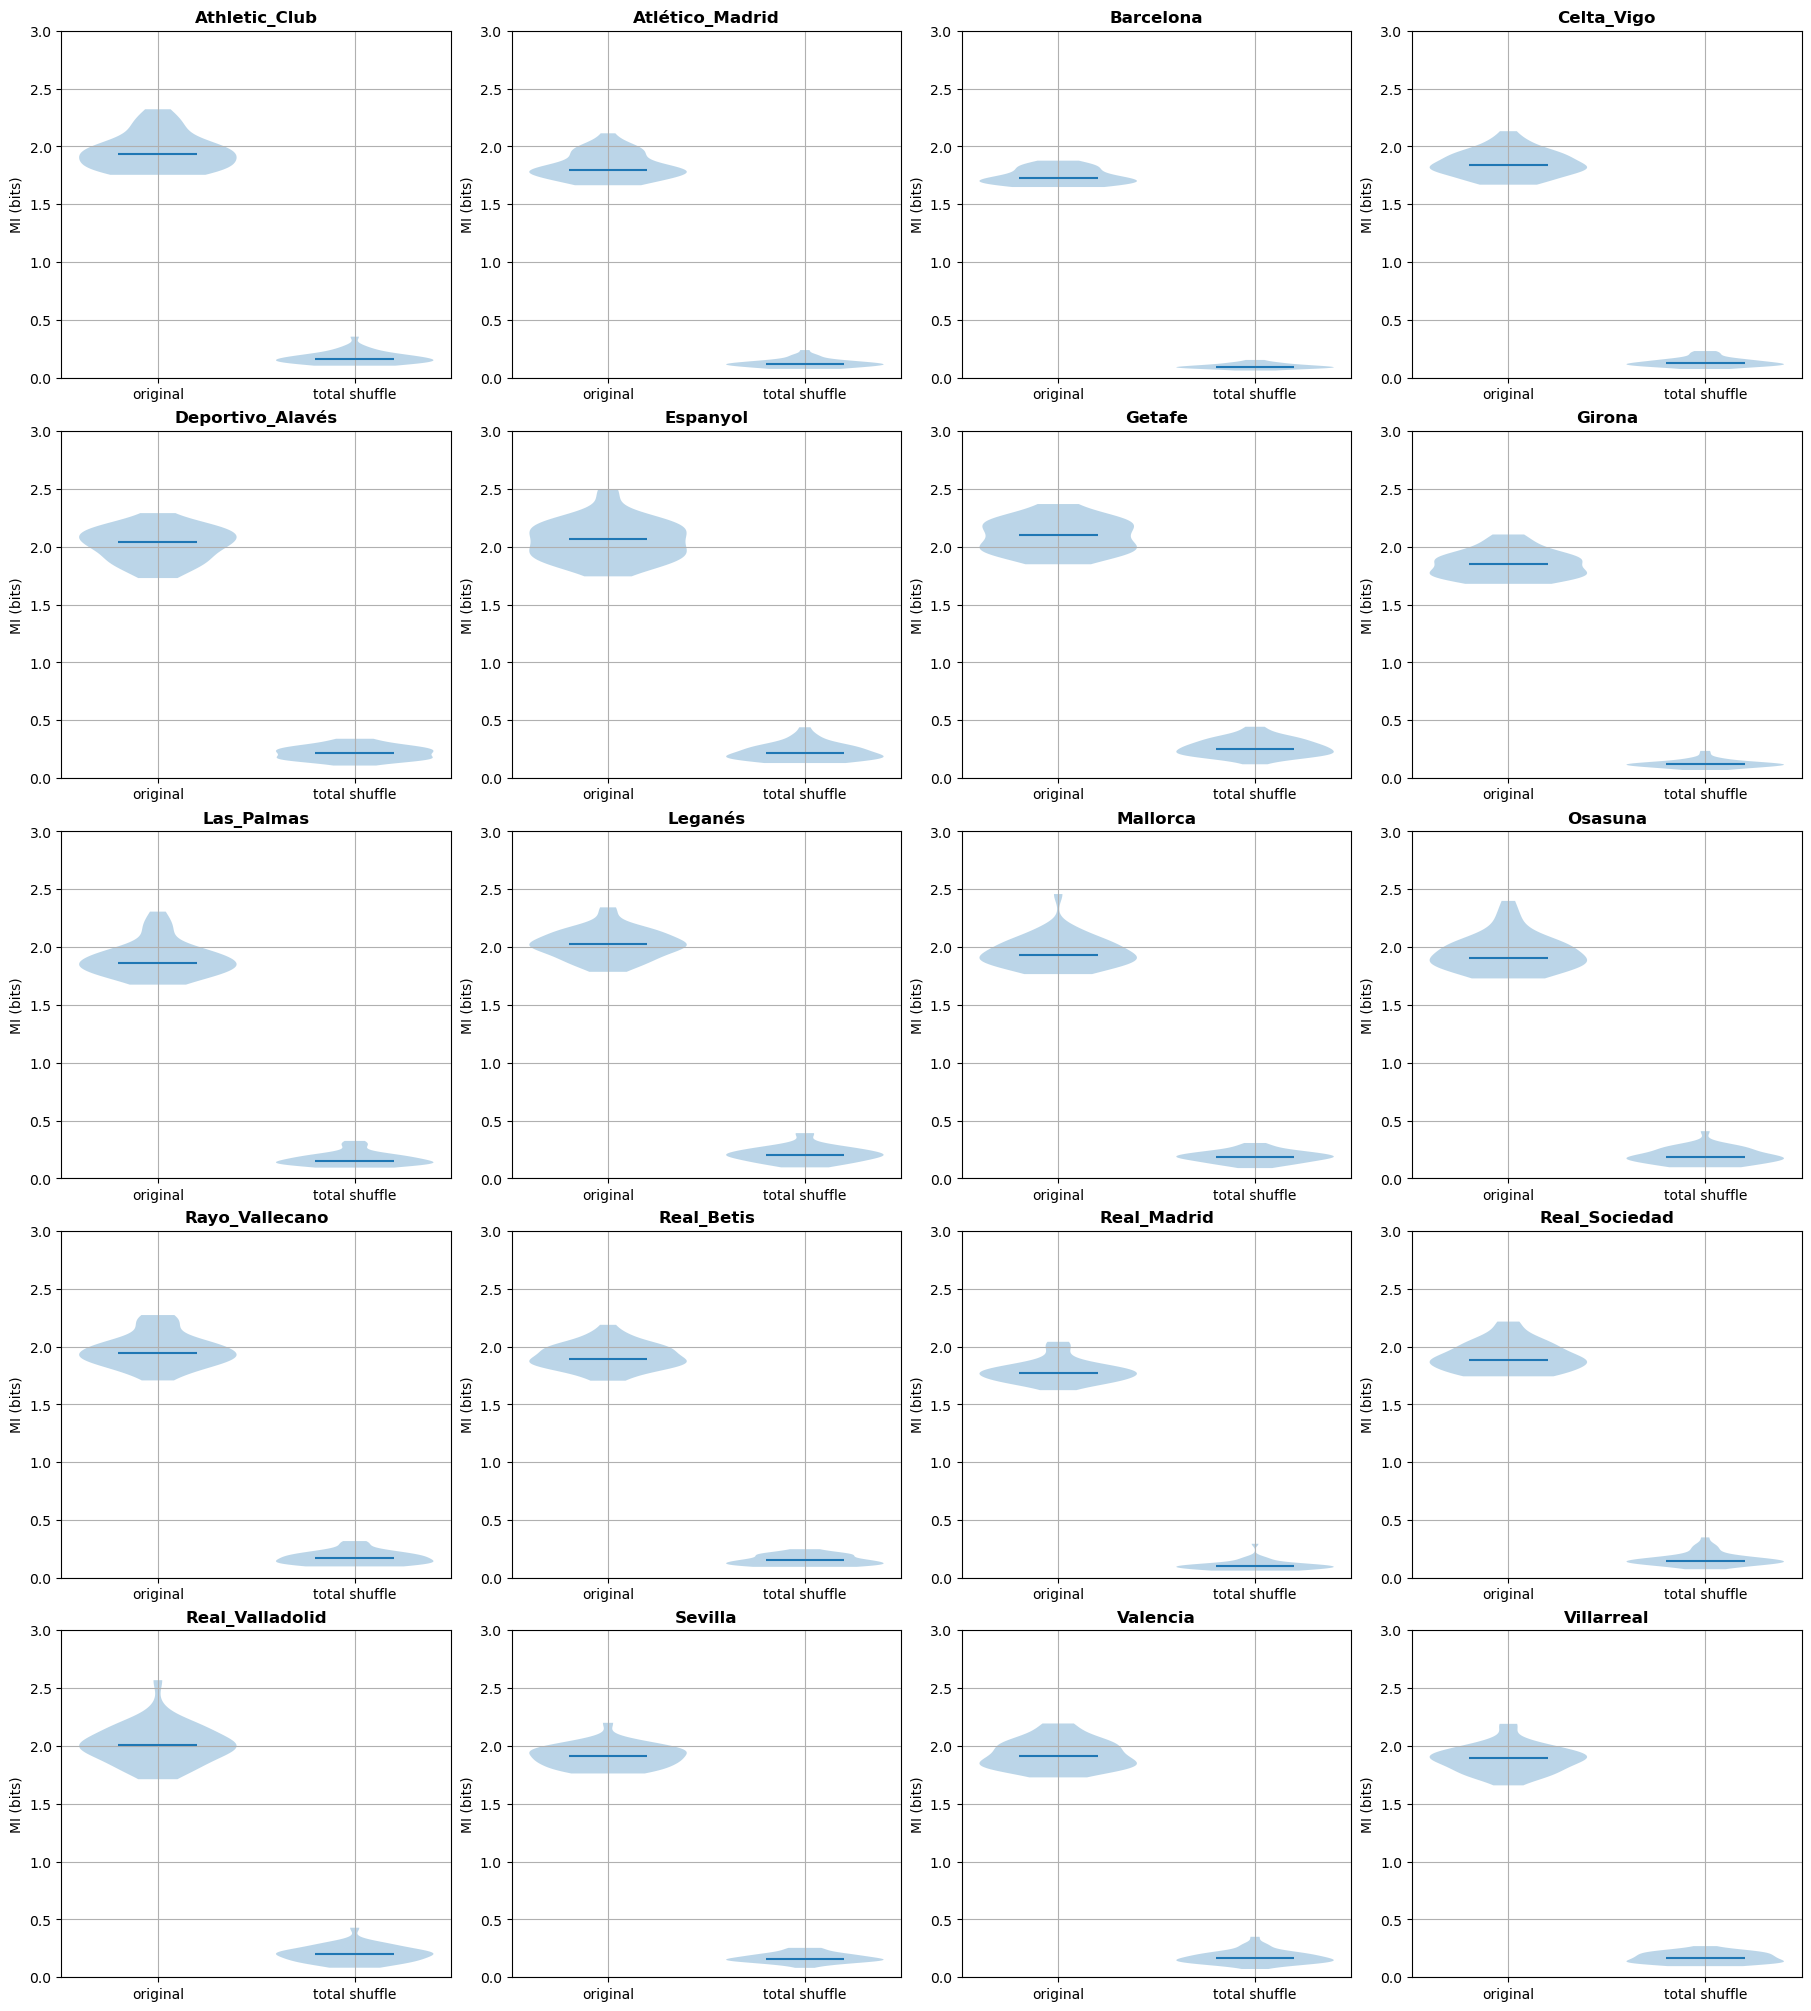

In [36]:
# ----------------------------
# CONFIG
# ----------------------------
file_list = [
    "Athletic_Club.csv",
    "Atlético_Madrid.csv",
    "Barcelona.csv",
    "Celta_Vigo.csv",
    "Deportivo_Alavés.csv",
    "Espanyol.csv",
    "Getafe.csv",
    "Girona.csv",
    "Las_Palmas.csv",
    "Leganés.csv",
    "Mallorca.csv",
    "Osasuna.csv",
    "Rayo_Vallecano.csv",
    "Real_Betis.csv",
    "Real_Madrid.csv",
    "Real_Sociedad.csv",
    "Real_Valladolid.csv",
    "Sevilla.csv",
    "Valencia.csv",
    "Villarreal.csv",
]

TEAM_PREFIXES = [Path(x).stem for x in file_list]
WORDS_COL = "words"
SEP = "-"

# Percorsi (Assicurati che siano corretti per il tuo ambiente)
ORIG_DIR = Path.home() / "Desktop" / "Podemi_and_Football-main" / "La_Liga_24_25_texts"
SHUF_DIR = Path.home() / "Desktop" / "Podemi_and_Football-main" / "Linguistic" / "La_Liga_24_25_full_shuffle"

# ----------------------------
# MI helpers
# ----------------------------
def word_to_phonemes(word: str, sep: str = "-"):
    return [p.strip() for p in word.split(sep) if p.strip()]

def flatten_bigrams_from_words(words: np.ndarray, sep: str = "-"):
    bigrams = []
    unigrams = []
    for w in words:
        ph = word_to_phonemes(w, sep)
        unigrams.extend(ph)
        for i in range(len(ph) - 1):
            bigrams.append((ph[i], ph[i + 1]))
    return unigrams, bigrams

def mutual_information_adjacent(unigrams, bigrams):
    if len(bigrams) == 0:
        return np.nan
    uni = Counter(unigrams)
    bi = Counter(bigrams)
    total_u = sum(uni.values())
    total_b = sum(bi.values())
    p = {k: v / total_u for k, v in uni.items()}
    mi = 0.0
    for (x, y), c in bi.items():
        pxy = c / total_b
        mi += pxy * math.log2(pxy / (p[x] * p[y]))
    return mi

def read_words_column(csv_path: Path, col="words") -> np.ndarray:
    try:
        df = pd.read_csv(csv_path)
    except Exception:
        try:
            df = pd.read_csv(csv_path, encoding="latin-1")
        except:
            return np.array([], dtype=object)
    if col not in df.columns:
        return np.array([], dtype=object)
    s = df[col].dropna().astype(str).str.strip()
    s = s[s != ""]
    return s.to_numpy()

def mi_for_match_file(csv_path: Path) -> float:
    words = read_words_column(csv_path, col=WORDS_COL)
    if len(words) == 0:
        return np.nan
    unigrams, bigrams = flatten_bigrams_from_words(words, sep=SEP)
    return mutual_information_adjacent(unigrams, bigrams)

# ----------------------------
# Raccolta dati e calcolo limiti globali
# ----------------------------
orig_files = [p for p in ORIG_DIR.iterdir() if p.is_file() and p.suffix.lower() == ".csv"] if ORIG_DIR.exists() else []
team_to_vals = {team: {"original": [], "total shuffle": []} for team in TEAM_PREFIXES}

all_mi_values = []

for team in TEAM_PREFIXES:
    team_files = [p for p in orig_files if p.name == f"{team}.csv" or p.name.startswith(team + "_")]
    for p in team_files:
        shuf_p = SHUF_DIR / p.name
        if not shuf_p.exists(): continue
        
        mi_o = mi_for_match_file(p)
        mi_s = mi_for_match_file(shuf_p)
        
        if not np.isnan(mi_o):
            team_to_vals[team]["original"].append(mi_o)
            all_mi_values.append(mi_o)
        if not np.isnan(mi_s):
            team_to_vals[team]["total shuffle"].append(mi_s)
            all_mi_values.append(mi_s)

# Calcolo limiti per asse Y comune
if all_mi_values:
    y_min = math.floor(min(all_mi_values) * 2) / 2  # Arrotonda per difetto allo 0.5 più vicino
    y_max = math.ceil(max(all_mi_values) * 2) / 2   # Arrotonda per eccesso allo 0.5 più vicino
else:
    y_min, y_max = 0, 5

# ----------------------------
# Plot
# ----------------------------
fig, axes = plt.subplots(5, 4, figsize=(18, 20), constrained_layout=True)
axes = axes.ravel()

for i, team in enumerate(TEAM_PREFIXES):
    ax = axes[i]
    orig_vals = np.array(team_to_vals[team]["original"], dtype=float)
    shuf_vals = np.array(team_to_vals[team]["total shuffle"], dtype=float)
    
    orig_vals = orig_vals[np.isfinite(orig_vals)]
    shuf_vals = shuf_vals[np.isfinite(shuf_vals)]
    
    if len(orig_vals) > 0 and len(shuf_vals) > 0:
        parts = ax.violinplot([orig_vals, shuf_vals], positions=[1, 2], 
                               widths=0.8, showmedians=True, showextrema=False)
    
    # --- UNIFORMITÀ SCALA ---
    ax.set_ylim(y_min, y_max)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    # ------------------------

    ax.set_title(f"{team}", fontweight="bold")
    ax.set_xticks([1, 2])
    ax.set_xticklabels(["original", "total shuffle"])
    ax.set_ylabel("MI (bits)")
    ax.grid()

    if len(orig_vals) == 0:
        ax.text(0.5, 0.5, "No data", transform=ax.transAxes, ha="center")

for j in range(len(TEAM_PREFIXES), len(axes)):
    axes[j].axis("off")

plt.show()

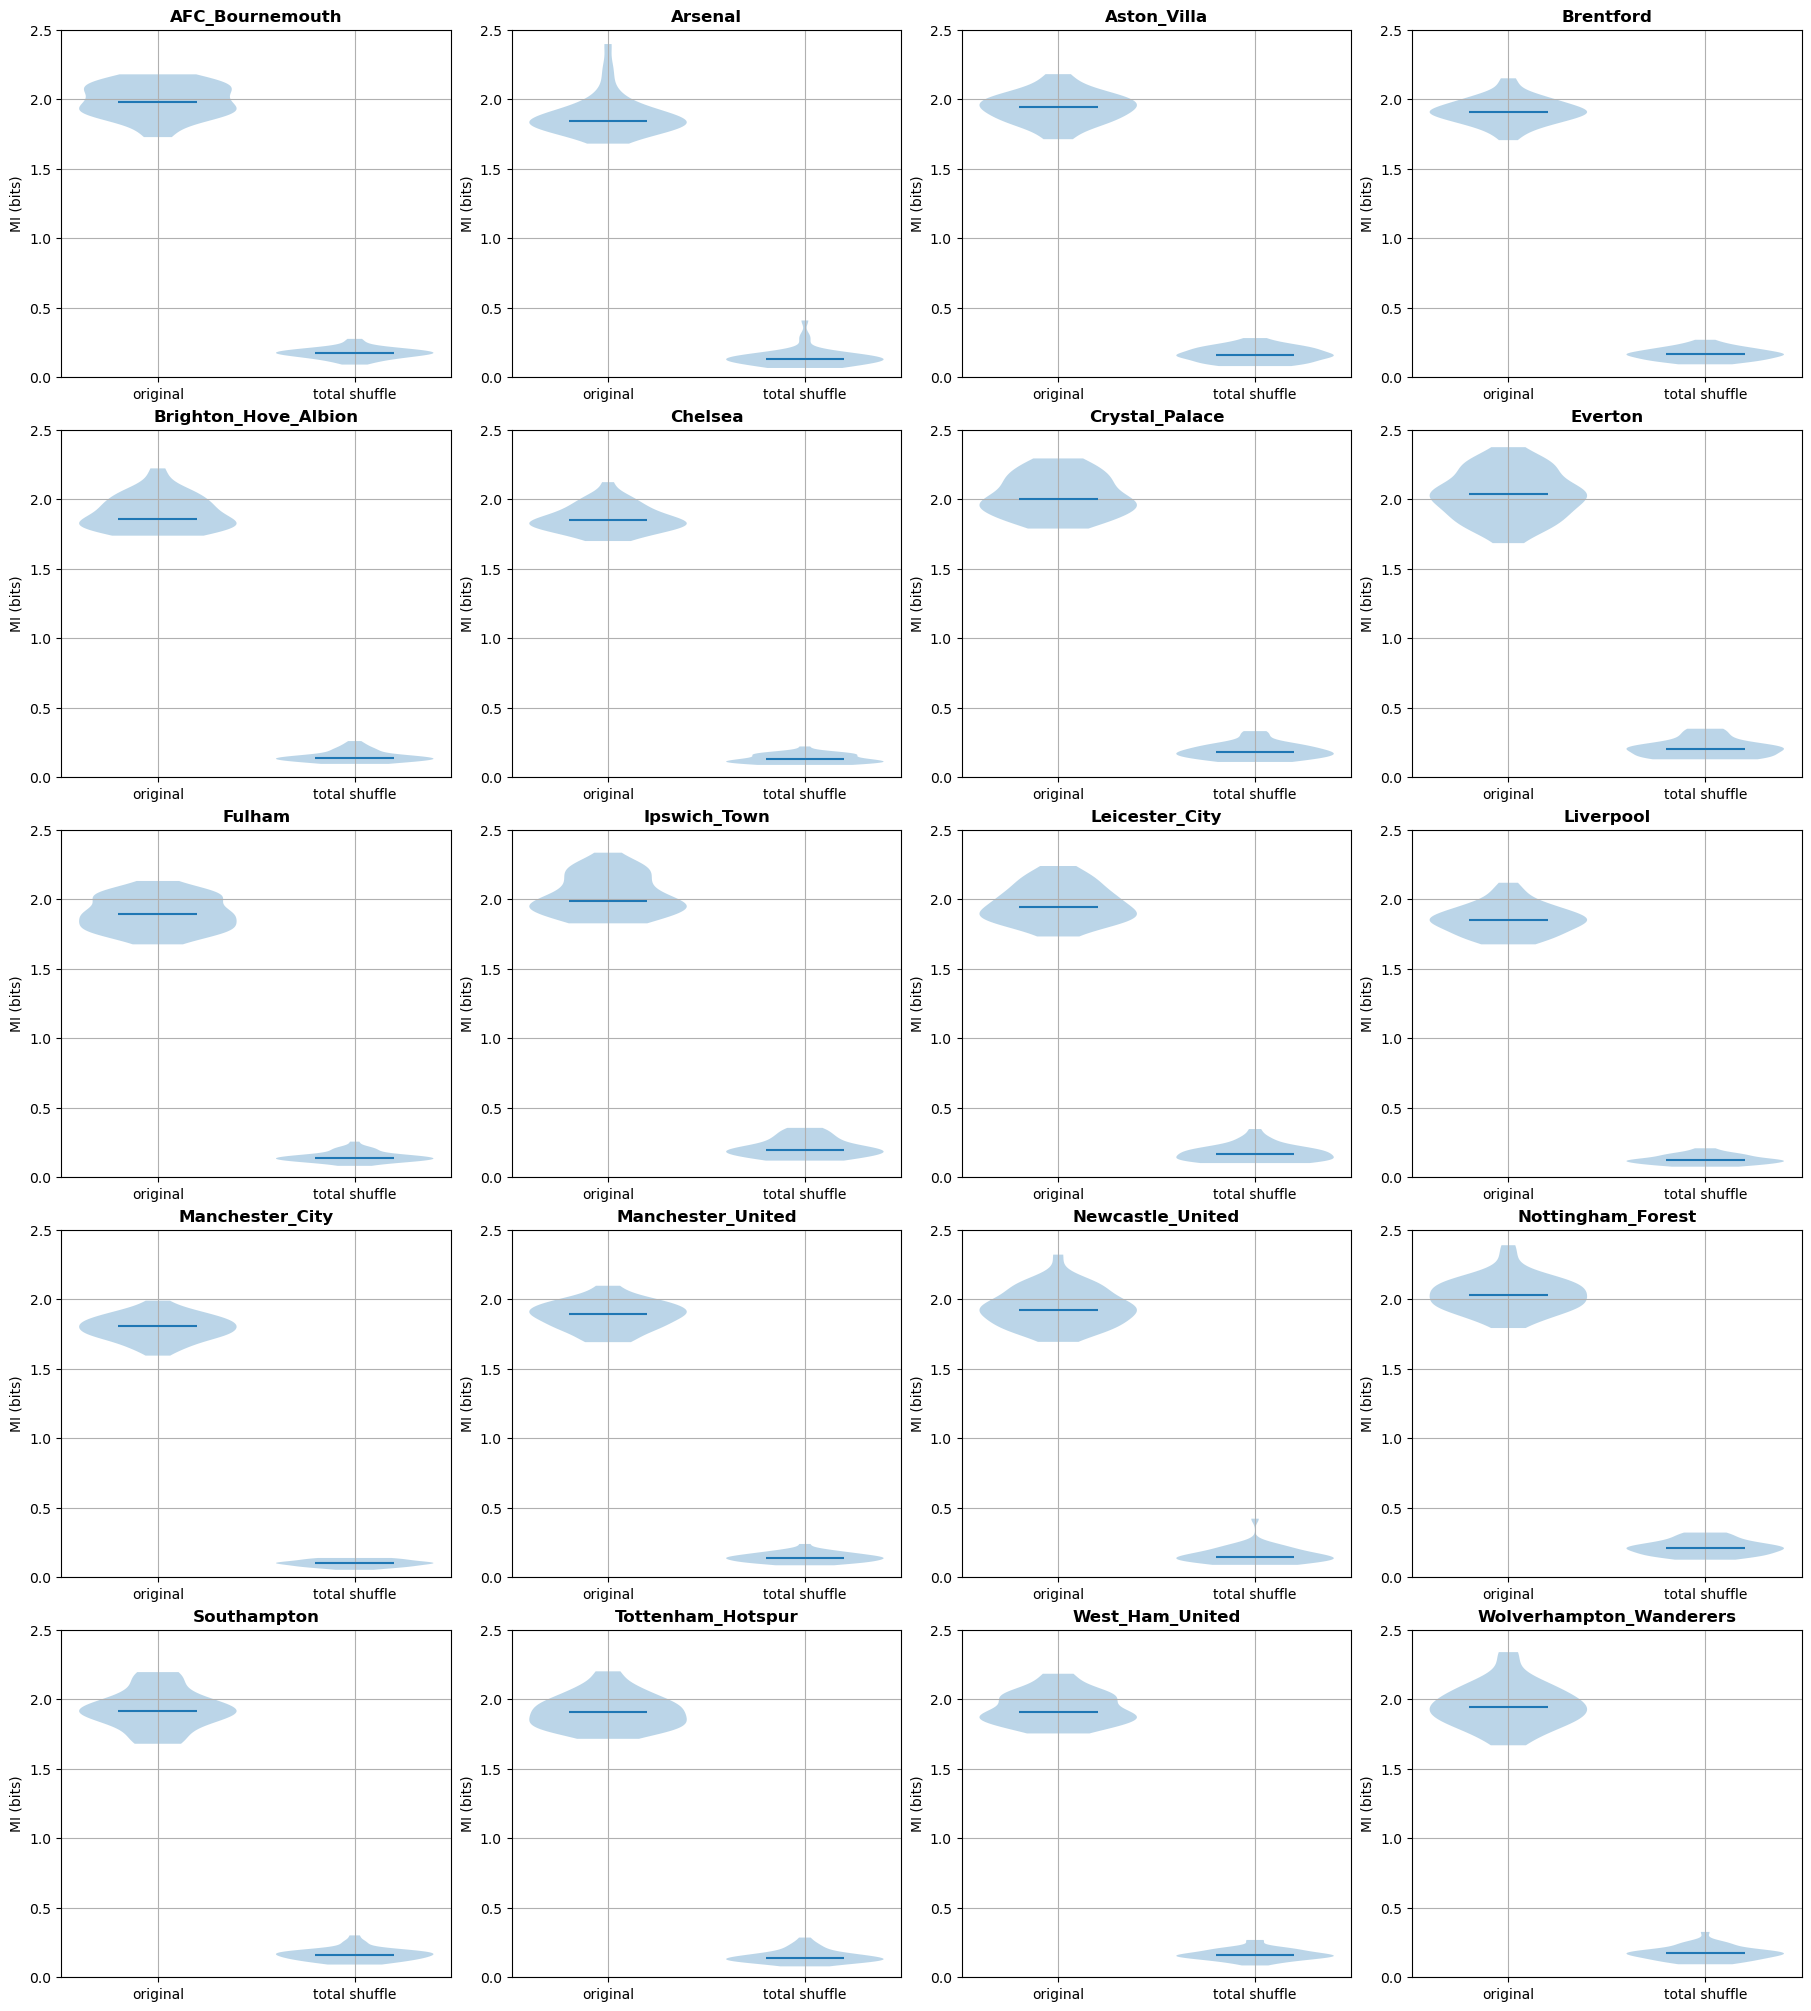

In [37]:
# ----------------------------
# CONFIG
# ----------------------------
file_list = [
    "AFC_Bournemouth.csv",
    "Arsenal.csv",
    "Aston_Villa.csv",
    "Brentford.csv",
    "Brighton_Hove_Albion.csv",
    "Chelsea.csv",
    "Crystal_Palace.csv",
    "Everton.csv",
    "Fulham.csv",
    "Ipswich_Town.csv",
    "Leicester_City.csv",
    "Liverpool.csv",
    "Manchester_City.csv",
    "Manchester_United.csv",
    "Newcastle_United.csv",
    "Nottingham_Forest.csv",
    "Southampton.csv",
    "Tottenham_Hotspur.csv",
    "West_Ham_United.csv",
    "Wolverhampton_Wanderers.csv",
]

TEAM_PREFIXES = [Path(x).stem for x in file_list]
WORDS_COL = "words"
SEP = "-"

# Percorsi (Assicurati che siano corretti per il tuo ambiente)
ORIG_DIR = Path.home() / "Desktop" / "Podemi_and_Football-main" / "Premier_League_24_25_texts"
SHUF_DIR = Path.home() / "Desktop" / "Podemi_and_Football-main" / "Linguistic" / "Premier_League_24_25_full_shuffle"

# ----------------------------
# MI helpers
# ----------------------------
def word_to_phonemes(word: str, sep: str = "-"):
    return [p.strip() for p in word.split(sep) if p.strip()]

def flatten_bigrams_from_words(words: np.ndarray, sep: str = "-"):
    bigrams = []
    unigrams = []
    for w in words:
        ph = word_to_phonemes(w, sep)
        unigrams.extend(ph)
        for i in range(len(ph) - 1):
            bigrams.append((ph[i], ph[i + 1]))
    return unigrams, bigrams

def mutual_information_adjacent(unigrams, bigrams):
    if len(bigrams) == 0:
        return np.nan
    uni = Counter(unigrams)
    bi = Counter(bigrams)
    total_u = sum(uni.values())
    total_b = sum(bi.values())
    p = {k: v / total_u for k, v in uni.items()}
    mi = 0.0
    for (x, y), c in bi.items():
        pxy = c / total_b
        mi += pxy * math.log2(pxy / (p[x] * p[y]))
    return mi

def read_words_column(csv_path: Path, col="words") -> np.ndarray:
    try:
        df = pd.read_csv(csv_path)
    except Exception:
        try:
            df = pd.read_csv(csv_path, encoding="latin-1")
        except:
            return np.array([], dtype=object)
    if col not in df.columns:
        return np.array([], dtype=object)
    s = df[col].dropna().astype(str).str.strip()
    s = s[s != ""]
    return s.to_numpy()

def mi_for_match_file(csv_path: Path) -> float:
    words = read_words_column(csv_path, col=WORDS_COL)
    if len(words) == 0:
        return np.nan
    unigrams, bigrams = flatten_bigrams_from_words(words, sep=SEP)
    return mutual_information_adjacent(unigrams, bigrams)

# ----------------------------
# Raccolta dati e calcolo limiti globali
# ----------------------------
orig_files = [p for p in ORIG_DIR.iterdir() if p.is_file() and p.suffix.lower() == ".csv"] if ORIG_DIR.exists() else []
team_to_vals = {team: {"original": [], "total shuffle": []} for team in TEAM_PREFIXES}

all_mi_values = []

for team in TEAM_PREFIXES:
    team_files = [p for p in orig_files if p.name == f"{team}.csv" or p.name.startswith(team + "_")]
    for p in team_files:
        shuf_p = SHUF_DIR / p.name
        if not shuf_p.exists(): continue
        
        mi_o = mi_for_match_file(p)
        mi_s = mi_for_match_file(shuf_p)
        
        if not np.isnan(mi_o):
            team_to_vals[team]["original"].append(mi_o)
            all_mi_values.append(mi_o)
        if not np.isnan(mi_s):
            team_to_vals[team]["total shuffle"].append(mi_s)
            all_mi_values.append(mi_s)

# Calcolo limiti per asse Y comune
if all_mi_values:
    y_min = math.floor(min(all_mi_values) * 2) / 2  # Arrotonda per difetto allo 0.5 più vicino
    y_max = math.ceil(max(all_mi_values) * 2) / 2   # Arrotonda per eccesso allo 0.5 più vicino
else:
    y_min, y_max = 0, 5

# ----------------------------
# Plot
# ----------------------------
fig, axes = plt.subplots(5, 4, figsize=(18, 20), constrained_layout=True)
axes = axes.ravel()

for i, team in enumerate(TEAM_PREFIXES):
    ax = axes[i]
    orig_vals = np.array(team_to_vals[team]["original"], dtype=float)
    shuf_vals = np.array(team_to_vals[team]["total shuffle"], dtype=float)
    
    orig_vals = orig_vals[np.isfinite(orig_vals)]
    shuf_vals = shuf_vals[np.isfinite(shuf_vals)]
    
    if len(orig_vals) > 0 and len(shuf_vals) > 0:
        parts = ax.violinplot([orig_vals, shuf_vals], positions=[1, 2], 
                               widths=0.8, showmedians=True, showextrema=False)
    
    # --- UNIFORMITÀ SCALA ---
    ax.set_ylim(y_min, y_max)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    # ------------------------

    ax.set_title(f"{team}", fontweight="bold")
    ax.set_xticks([1, 2])
    ax.set_xticklabels(["original", "total shuffle"])
    ax.set_ylabel("MI (bits)")
    ax.grid()

    if len(orig_vals) == 0:
        ax.text(0.5, 0.5, "No data", transform=ax.transAxes, ha="center")

for j in range(len(TEAM_PREFIXES), len(axes)):
    axes[j].axis("off")

plt.show()

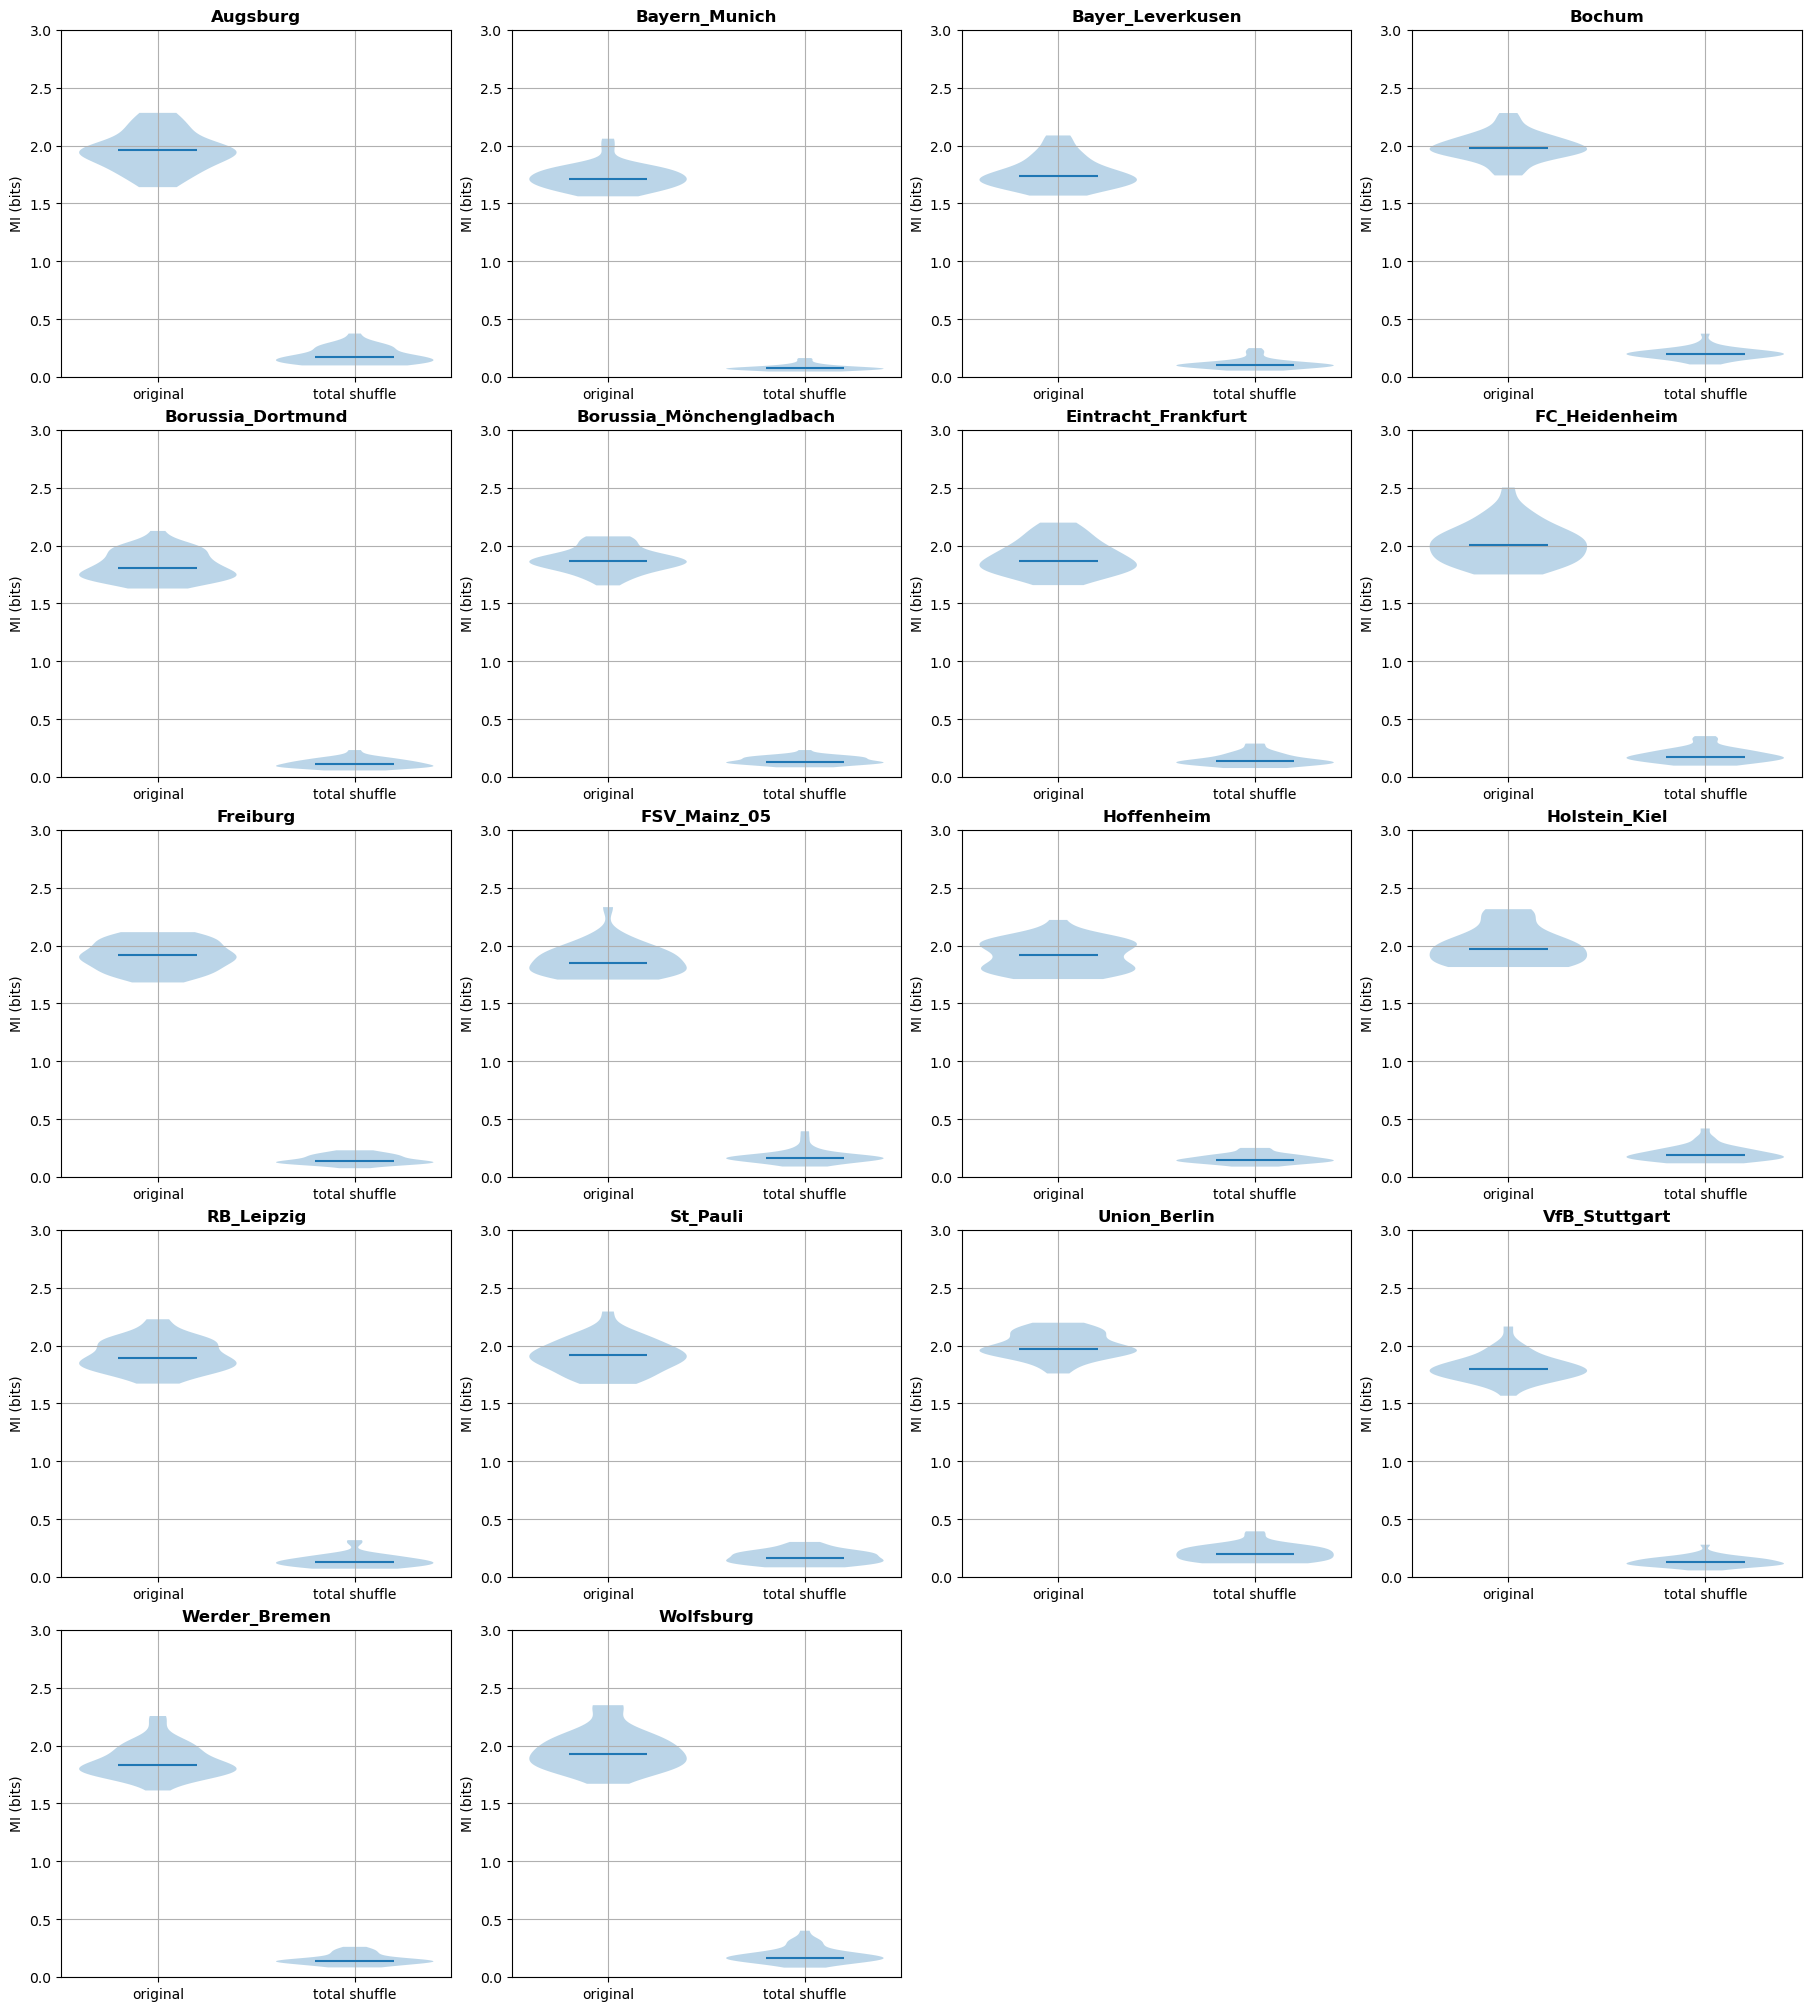

In [38]:
# ----------------------------
# CONFIG
# ----------------------------
file_list = [
    "Augsburg.csv",
    "Bayern_Munich.csv",
    "Bayer_Leverkusen.csv",
    "Bochum.csv",
    "Borussia_Dortmund.csv",
    "Borussia_Mönchengladbach.csv",
    "Eintracht_Frankfurt.csv",
    "FC_Heidenheim.csv",
    "Freiburg.csv",
    "FSV_Mainz_05.csv",
    "Hoffenheim.csv",
    "Holstein_Kiel.csv",
    "RB_Leipzig.csv",
    "St_Pauli.csv",
    "Union_Berlin.csv",
    "VfB_Stuttgart.csv",
    "Werder_Bremen.csv",
    "Wolfsburg.csv",
]

TEAM_PREFIXES = [Path(x).stem for x in file_list]
WORDS_COL = "words"
SEP = "-"

# Percorsi (Assicurati che siano corretti per il tuo ambiente)
ORIG_DIR = Path.home() / "Desktop" / "Podemi_and_Football-main" / "Bundesliga_24_25_texts"
SHUF_DIR = Path.home() / "Desktop" / "Podemi_and_Football-main" / "Linguistic" / "Bundesliga_24_25_full_shuffle"

# ----------------------------
# MI helpers
# ----------------------------
def word_to_phonemes(word: str, sep: str = "-"):
    return [p.strip() for p in word.split(sep) if p.strip()]

def flatten_bigrams_from_words(words: np.ndarray, sep: str = "-"):
    bigrams = []
    unigrams = []
    for w in words:
        ph = word_to_phonemes(w, sep)
        unigrams.extend(ph)
        for i in range(len(ph) - 1):
            bigrams.append((ph[i], ph[i + 1]))
    return unigrams, bigrams

def mutual_information_adjacent(unigrams, bigrams):
    if len(bigrams) == 0:
        return np.nan
    uni = Counter(unigrams)
    bi = Counter(bigrams)
    total_u = sum(uni.values())
    total_b = sum(bi.values())
    p = {k: v / total_u for k, v in uni.items()}
    mi = 0.0
    for (x, y), c in bi.items():
        pxy = c / total_b
        mi += pxy * math.log2(pxy / (p[x] * p[y]))
    return mi

def read_words_column(csv_path: Path, col="words") -> np.ndarray:
    try:
        df = pd.read_csv(csv_path)
    except Exception:
        try:
            df = pd.read_csv(csv_path, encoding="latin-1")
        except:
            return np.array([], dtype=object)
    if col not in df.columns:
        return np.array([], dtype=object)
    s = df[col].dropna().astype(str).str.strip()
    s = s[s != ""]
    return s.to_numpy()

def mi_for_match_file(csv_path: Path) -> float:
    words = read_words_column(csv_path, col=WORDS_COL)
    if len(words) == 0:
        return np.nan
    unigrams, bigrams = flatten_bigrams_from_words(words, sep=SEP)
    return mutual_information_adjacent(unigrams, bigrams)

# ----------------------------
# Raccolta dati e calcolo limiti globali
# ----------------------------
orig_files = [p for p in ORIG_DIR.iterdir() if p.is_file() and p.suffix.lower() == ".csv"] if ORIG_DIR.exists() else []
team_to_vals = {team: {"original": [], "total shuffle": []} for team in TEAM_PREFIXES}

all_mi_values = []

for team in TEAM_PREFIXES:
    team_files = [p for p in orig_files if p.name == f"{team}.csv" or p.name.startswith(team + "_")]
    for p in team_files:
        shuf_p = SHUF_DIR / p.name
        if not shuf_p.exists(): continue
        
        mi_o = mi_for_match_file(p)
        mi_s = mi_for_match_file(shuf_p)
        
        if not np.isnan(mi_o):
            team_to_vals[team]["original"].append(mi_o)
            all_mi_values.append(mi_o)
        if not np.isnan(mi_s):
            team_to_vals[team]["total shuffle"].append(mi_s)
            all_mi_values.append(mi_s)

# Calcolo limiti per asse Y comune
if all_mi_values:
    y_min = math.floor(min(all_mi_values) * 2) / 2  # Arrotonda per difetto allo 0.5 più vicino
    y_max = math.ceil(max(all_mi_values) * 2) / 2   # Arrotonda per eccesso allo 0.5 più vicino
else:
    y_min, y_max = 0, 5

# ----------------------------
# Plot
# ----------------------------
fig, axes = plt.subplots(5, 4, figsize=(18, 20), constrained_layout=True)
axes = axes.ravel()

for i, team in enumerate(TEAM_PREFIXES):
    ax = axes[i]
    orig_vals = np.array(team_to_vals[team]["original"], dtype=float)
    shuf_vals = np.array(team_to_vals[team]["total shuffle"], dtype=float)
    
    orig_vals = orig_vals[np.isfinite(orig_vals)]
    shuf_vals = shuf_vals[np.isfinite(shuf_vals)]
    
    if len(orig_vals) > 0 and len(shuf_vals) > 0:
        parts = ax.violinplot([orig_vals, shuf_vals], positions=[1, 2], 
                               widths=0.8, showmedians=True, showextrema=False)
    
    # --- UNIFORMITÀ SCALA ---
    ax.set_ylim(y_min, y_max)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    # ------------------------

    ax.set_title(f"{team}", fontweight="bold")
    ax.set_xticks([1, 2])
    ax.set_xticklabels(["original", "total shuffle"])
    ax.set_ylabel("MI (bits)")
    ax.grid()

    if len(orig_vals) == 0:
        ax.text(0.5, 0.5, "No data", transform=ax.transAxes, ha="center")

for j in range(len(TEAM_PREFIXES), len(axes)):
    axes[j].axis("off")

plt.show()